In [708]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
import astropy.constants as C
from math import ceil
import reverse_indices_2d as ri
import astropy as aspy
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline as spline
import cmasher as cm
import copy
import ipywidgets as widgets
from matplotlib.widgets import Button, RadioButtons

%matplotlib inline
#%matplotlib widget

In [709]:
run ../scripts/rc_params.py

rcParams updated :)


In [710]:
#import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('png')

## The Catalogs

In [711]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')

phatter['full_index'] = np.arange(len(phatter))
phatter['MATCH'] = np.full(len(phatter), -999999)
raw_f110 = phatter.F110W_VEGA.evaluate()
raw_f160 = phatter.F160W_VEGA.evaluate()

phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

phatter = phatter[
        (phatter.F110W_SNR > 4) & (phatter.F110W_SHARP**2 < 0.15) & (phatter.F110W_CROWD < 2.25) & 
        (phatter.F160W_SNR > 4) & (phatter.F160W_SHARP**2 < 0.15) & 
        (phatter.F160W_CROWD < 2.25) & (phatter.F110W_VEGA == phatter.F110W_VEGA)
       ]

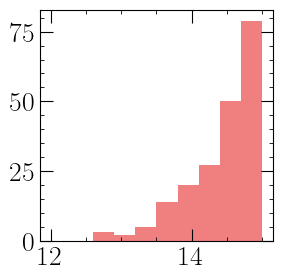

In [712]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,3)
ax.hist(phatter.F160W_VEGA.evaluate(selection='IR_GST'), range=[12, 15]);
plt.show();

In [713]:
brt, = np.where(phatter.F160W_VEGA.evaluate(selection='IR_GST') < 15)

In [714]:
len(brt)

200

In [715]:
bstars = aspy.table.Table([phatter.RA.evaluate(selection='IR_GST')[brt], phatter.DEC.evaluate(selection='IR_GST')[brt]], 
                         names=['ra', 'dec'])

In [716]:
bstars.write('./hst_bright.csv', overwrite=True)

In [717]:
#Add index to PHATTER dataframe

###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

In [718]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(), phatter.RA.min()
dec_max, dec_min = phatter.DEC.max(), phatter.DEC.min()
ra_m33 = phatter.RA.mean()
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [719]:
ra_m33, dec_m33

(array(23.48688753), array(30.66646033))

In [720]:
#Extract RA, and DEC  with GST cuts for easy plotting later
ra_gst, dec_gst = phatter.RA.evaluate(), phatter.DEC.evaluate()

In [721]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.4f} - {:.4f}'.format(ra_min, ra_max))
print('DEC (deg): {:.4f} - {:.4f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.3422 - 23.6613
DEC (deg): 30.4894 - 30.8491


In [722]:
sage_all = fits.open('./sage_lmc_smc.fits')
sage_all.info()

Filename: ./sage_lmc_smc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      72   ()      
  1  II_305_archive    1 BinTableHDU    154   9094829R x 28C   [B, 19A, D, D, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, D, D, D, D]   
  2  II_305_catalog    1 BinTableHDU    149   8414394R x 28C   [D, D, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, J, E, E, D, D, D, D, A, 19A]   


In [16]:
sage1 = aspy.table.Table(sage_all[1].data)

In [17]:
lmc_only, = np.where(sage1['RAJ2000'] > 50)

In [18]:
sfit = fits.open('./spitzer_m33_mosaic.fits')
sfit.info()

Filename: ./spitzer_m33_mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (5332, 6070)   float32   


In [19]:
sfit1 = aspy.table.Table(sfit[0].data)

In [20]:
def sex2diff(ra,dec,ra0,dec0):
        dRA, dDec = (ra-ra0), (dec-dec0)
        return dRA*np.cos(dec0),dDec

In [21]:
sw = WCS(sfit[0].header)
cir = Cutout2D(sfit[0].data,SkyCoord(ra_m33*u.deg,dec_m33*u.deg,frame='icrs'),
        size=[0.6,0.6]*u.deg,wcs=sw,mode='partial',fill_value=0)
swcs = cir.wcs
cim = cir.data

ra_ir, dec_ir = swcs.all_pix2world(np.arange(cim.shape[1]), np.arange(cim.shape[0]), 0)

dra0_ir,ddec0_ir = sex2diff(ra_ir*u.deg,dec_ir*u.deg,ra_m33*u.deg,dec_m33*u.deg)
dra_ir,ddec_ir = np.meshgrid(dra0_ir.value,ddec0_ir.value)

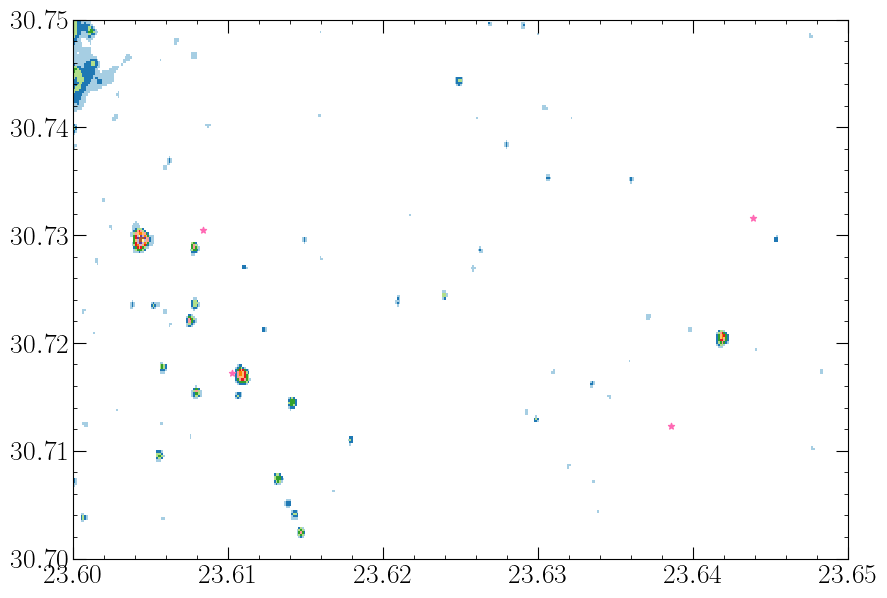

In [22]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,7)

cmap = cm.get_sub_cmap('Paired', 0.0, 1.0)
cmap.set_under('w')
plot = ax.imshow(cim.T[::-1,:], origin='lower',  
          norm=mpl.colors.LogNorm(vmin=1, vmax=1e2), 
          cmap=cmap, 
          aspect='auto', 
          interpolation='nearest', 
          extent=[ra_ir.max(), ra_ir.min(), dec_ir.min(),dec_ir.max()]
                );
ax.scatter(bstars['ra'], bstars['dec'], s=20, marker='*', c='hotpink');

#ax.invert_xaxis();
ax.set_xlim(23.6, 23.65)
ax.set_ylim(30.7, 30.75);
#ax.set_aspect(m33_ar)
#ax.scatter(bstars['ra'], bstars['dec'], edgecolor='fuchsia', facecolor='none', s=10)


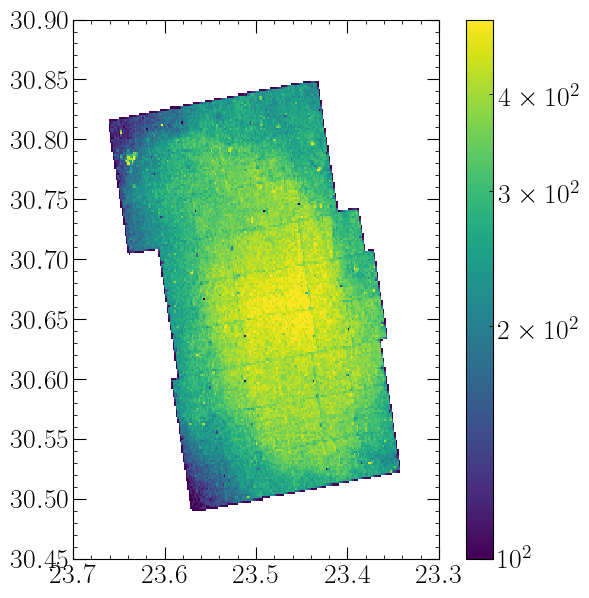

In [23]:
fig, ax = plt.subplots(1)

plot = ax.hist2d(ra_gst, dec_gst, bins=200, cmap='viridis', norm=mpl.colors.LogNorm(vmin=1e2, vmax=5e2));
ax.set_xlim(23.3, 23.7)
ax.set_ylim(30.45, 30.9)
ax.invert_xaxis()

ax.set_aspect(m33_ar);

plt.colorbar(plot[3], ax=ax);

In [24]:
spitz_fits = fits.open('./spitzer_m33.fits')
spitz_fits.info()

Filename: ./spitzer_m33.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  J_ApJS_219_42_psc    1 BinTableHDU    111   78841R x 20C   [D, D, E, E, E, E, E, E, A, E, E, E, A, E, E, E, A, E, E, 7A]   


In [25]:
names = ['ra', 'dec', 'mag36', 'e36', 'd36', 'mag45', 'e45', 'd45', 'blank1', 'mag58', 'e58', 'd58', 'blank2', 'mag80', 'e80', 'd80', 'blank3', 'mag24', 'e24', 'Gal']
spitz_all = aspy.table.Table(spitz_fits[1].data, names=names)
spitz_all.remove_columns(['blank1', 'blank2', 'blank3'])

In [26]:
cut, = np.where((spitz_all['ra'] >= 23.342) & (spitz_all['ra'] <= 23.662) & (spitz_all['dec'] >= 30.489) & (spitz_all['dec'] <= 30.850))

In [27]:
spitz_ftprnt = spitz_all[cut]
#spitz_ftprnt.write('./spitzer_phatter_ftprnt.csv')

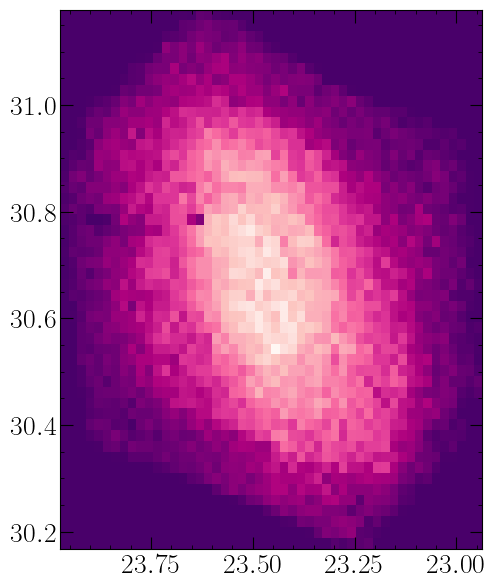

In [28]:
fig, ax = plt.subplots(1)

ax.hist2d(spitz_all['ra'], spitz_all['dec'], bins=50);
#ax.scatter(ra_gst, dec_gst, s=1, c='limegreen');
ax.invert_xaxis();
ax.set_aspect(m33_ar);

In [29]:
m33_verts = [(23.66, 30.815), #top left
             (23.434, 30.848), #top right
             (23.412, 30.738), (23.389, 30.742), (23.378, 30.71), (23.368, 30.711), (23.351, 30.63), (23.359, 30.63), 
             (23.337, 30.52), #bottom right
             (23.567, 30.485), #bottom left
             (23.596, 30.6), (23.588, 30.603), (23.609, 30.706), (23.641, 30.702), 
             (23.67, 30.82)]

m33_codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY ]

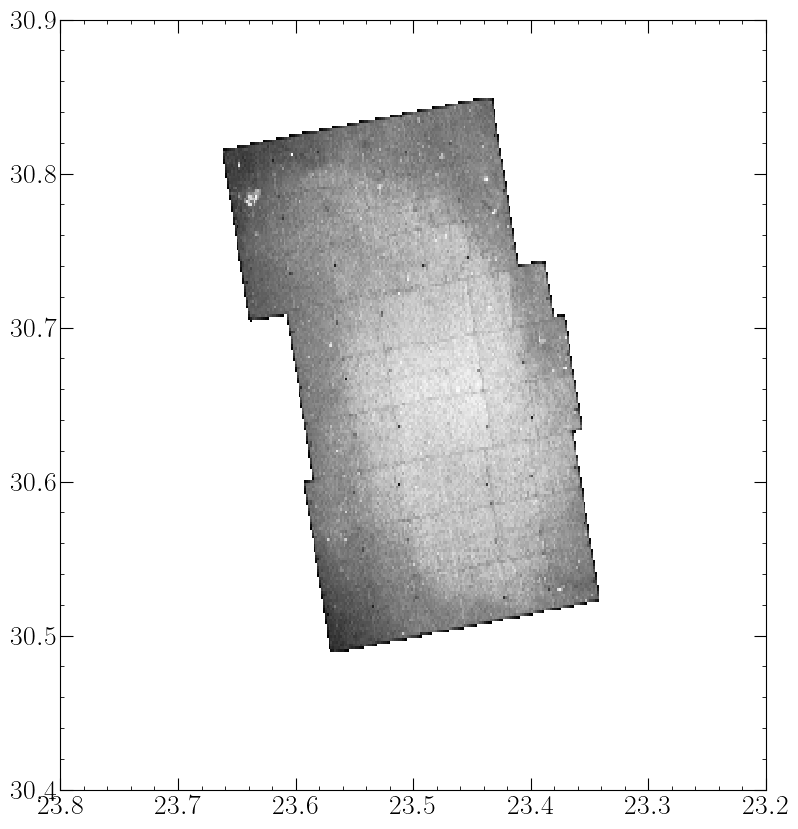

In [30]:
#limit sources to phatter footprint

fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

cmap=cm.get_sub_cmap('Greys_r', 0.0, 1.0)
cmap.set_under('w')

ax.set_aspect(m33_ar)
#ax.scatter(ra_gst, dec_gst, s=0.001, c='grey', alpha=0.1)
plot = ax.hist2d(ra_gst, dec_gst, bins=200, cmap=cmap, vmin=1)
ax.set_xlim(23.2, 23.8)
ax.set_ylim(30.4, 30.9)

path = Path(m33_verts, m33_codes)
patch = patches.PathPatch(path, edgecolor='orange', facecolor='none', linewidth=4, alpha=0.8)
#ax.add_patch(patch)

spitz_pts = np.stack((spitz_ftprnt['ra'], spitz_ftprnt['dec']), axis=1)
in_ftprnt = path.contains_points(spitz_pts)

#ax.scatter(spitz_ftprnt['ra'][in_ftprnt], spitz_ftprnt['dec'][in_ftprnt], s=0.1, c='black')

ax.invert_xaxis();

mpl.image.imsave('./m33.png', plot[0])

In [193]:
def get_edges(xdata, ydata, bins):

    h, xedges, yedges = np.histogram2d(xdata, ydata, bins=bins, range=[[23.3, 23.7], [30.45, 30.9]])

    nz = np.where(h != 0)
    h[nz] = 1
    xi, yi = [], []
    x_coords = []
    y_coords = []
    xpts = []
    ypts = []
    for i,l in enumerate(h.T):
        for j,k in enumerate(l[:-10]):
            j = j+5
            if (l[j-5:j] == [0,0,0,0,1]).all() or (l[j:j+5] == [1, 0, 0, 0, 0]).all():
                cx, cy = xedges[j+1], yedges[i+1]
                xi.append(j), yi.append(i)
                x_coords.append(cx)
                y_coords.append(cy)
            elif (l[j:j+5] == [1, 0, 0, 0, 0]).all():
                cx, cy = xedges[j+1], yedges[i+1]
                xi.append(j), yi.append(i)
                x_coords.append(cx)
                y_coords.append(cy)
    
    num=2
    for i,x in enumerate(x_coords):
        y = y_coords[i]
        
        if i in [0, 1, len(x_coords)-1, len(x_coords)-2]:
            xpts.append(x)
            ypts.append(y)
        else:
            a, b = np.min(x_coords[i-num:i+num+1]), np.max(x_coords[i-num:i+num+1])
            c, d = np.min(y_coords[i-num:i+num+1]), np.max(y_coords[i-num:i+num+1])
            if a==x or b==x or c==y or d==y:
                xpts.append(x)
                ypts.append(y)
            
    #return np.array(xpts), np.array(ypts)
    return x_coords, y_coords

In [194]:
xs, ys = get_edges(ra_gst, dec_gst, 500)

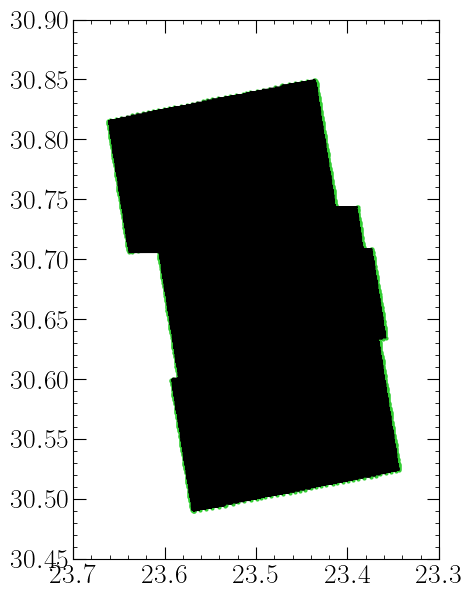

In [228]:
fig, ax = plt.subplots(1)
ax.set_aspect(m33_ar)
plot = ax.hist2d(ra_gst, dec_gst, bins=500, range=[[23.3, 23.7], [30.45, 30.9]], cmap=cmap, vmin=1)
ax.scatter(xs, ys, s=4, c='limegreen');


xv, yv = xs + [xs[0]], ys + [ys[0]]
verts = np.stack((xv, yv), axis=1)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 2) + [Path.CLOSEPOLY]
path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='orange', facecolor='none', linewidth=4, alpha=0.5)

ax.add_patch(patch)

ax.invert_xaxis();

In [181]:
left, = np.where(xs < 23.5)
right, = np.where(xs > 23.5)
l2, = np.where(xs < 23.38)
l3, = np.where(xs[left] > 23.38)


l6, = np.where(xs[right] < 23.62)
l7, = np.where(xs[right] > 23.62)
l8, = np.where(xs[left] < 23.4)
l9, = np.where(xs[left] > 23.405)
q1l, = np.where((ys[left] > 30.63) & (ys[left] < 30.65))
q1r, = np.where((ys[right] > 30.575) & (ys[right] < 30.625))

a, b = np.argmin(ys[left]), np.argmax(ys[left])
c, d = np.argmin(ys[right]), np.argmax(ys[right])
e, f = np.argmax(xs[left][q1l]), np.argmin(xs[left][q1l])
g, h = np.argmax(xs[right][q1r]), np.argmin(xs[right][q1r])
m, n = np.argmax(ys[l2]), np.argmin(ys[left][l3])
p, q = np.argmax(ys[right][l6]), np.argmin(ys[right][l7])
r, s = np.argmax(ys[left][l8]), np.argmin(ys[left][l9])


xcor = np.array([xs[left][a], xs[left][q1l][e], xs[left][q1l][f], 
                 xs[l2][m], xs[left][l3][n], xs[left][l8][r], xs[left][l9][s],
                 xs[left][b], xs[right][d], xs[right][l7][q], xs[right][l6][p],
                 xs[right][q1r][h], xs[right][q1r][g], 
                 xs[right][c], xs[left][a] 
       ])

ycor = np.array([ys[left][a], ys[left][q1l][e], ys[left][q1l][f], 
                 ys[l2][m], ys[left][l3][n], ys[left][l8][r], ys[left][l9][s],
                 ys[left][b], ys[right][d], ys[right][l7][q], ys[right][l6][p],
                 ys[right][q1r][h], ys[right][q1r][g], 
                 ys[right][c], ys[left][a]
       ])

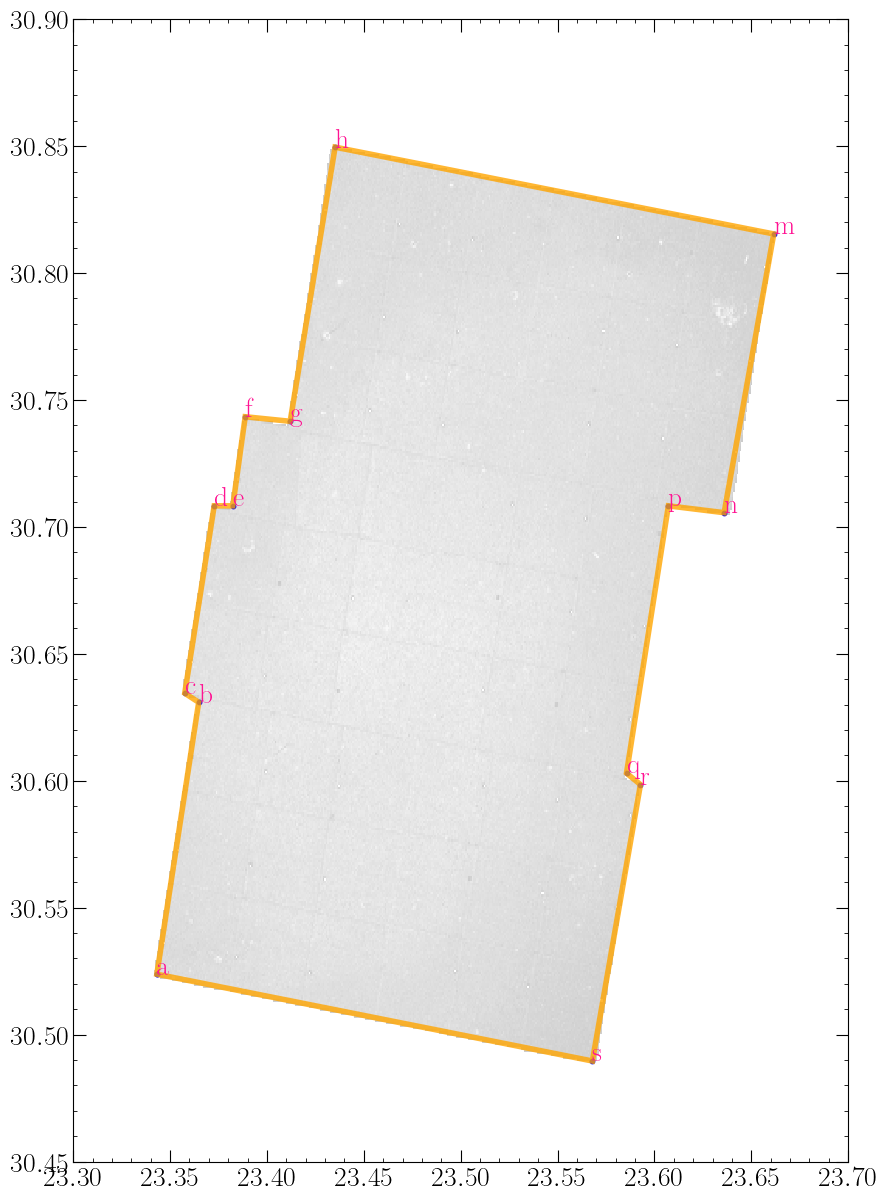

In [222]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,15)
ax.set_aspect(m33_ar)
plot = ax.hist2d(ra_gst, dec_gst, bins=500, range=[[23.3, 23.7], [30.45, 30.9]], cmap=cmap, vmin=1, alpha=0.2)
ax.scatter(xcor, ycor, s=10, c='blue');
#ax.invert_xaxis();
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n', 'p', 'q', 'r', 's']
for i,l in enumerate(letters):
    ax.text(xcor[i], ycor[i], l, fontsize=20, c='deeppink')
    
verts = np.stack((xcor, ycor), axis=1)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 2) + [Path.CLOSEPOLY]

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='orange', facecolor='none', linewidth=4, alpha=0.8)
ax.add_patch(patch)#

## Data Reduction

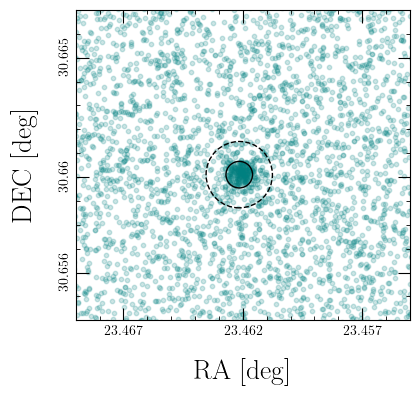

In [761]:
#Define a circle around the center of the galaxy where crowding has the most effect

fig, ax = plt.subplots(1)
fig.set_size_inches(5,5)
fig.tight_layout()

plt.rcParams["axes.axisbelow"] = False



qc, = np.where(phatter.F160W_VEGA.evaluate() <= 20)
plot = ax.scatter(ra_gst[qc], dec_gst[qc],
                 #bins=300,
                 #cmap=cmap,
                 #vmax=20
                  c='teal', s=10, alpha=0.2
                );
center_ra, center_dec = 23.46215, 30.6601
ctr = patches.Circle((center_ra, center_dec), 5/3600, edgecolor='black', facecolor=(0,0,0,0), linewidth=1, linestyle='--')
csize = patches.Circle((center_ra, center_dec), 2/3600, edgecolor='black', facecolor=(0,0,0,0), linewidth=1)
ax.add_patch(ctr)
ax.add_patch(csize)

#zoom in on center
ax.set_xlim(23.455,23.469)
ax.set_ylim(30.654,30.667)
ax.set_xticks([23.457, 23.462, 23.467])
ax.set_yticks([30.656, 30.66, 30.665])

ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='y', labelrotation=90)
ax.set_yticklabels([30.656, 30.66, 30.665], va='center')

ax.set_xlabel('RA [deg]', fontsize=20)
ax.set_ylabel('DEC [deg]', fontsize=20)

ax.set_aspect(1)
ax.invert_xaxis()

plt.savefig('./images/ctr_cutout.png', bbox_inches='tight')

In [762]:
ra_gst.max(), ra_gst.min(), dec_gst.max(), dec_gst.min()

(23.661299708544714,
 23.342150134149467,
 30.849057943403103,
 30.489384298850307)

In [763]:
#remove the spitzer sources within the central circle
ctr_path = ctr.get_path()
ctr_transform = ctr.get_patch_transform()
c_path = ctr_transform.transform_path(ctr_path)

spitz_pts = np.stack((spitz_ftprnt['ra'][in_ftprnt], spitz_ftprnt['dec'][in_ftprnt]), axis=1)
no_ctr, = np.where(~c_path.contains_points(spitz_pts))

spitzer = spitz_ftprnt[in_ftprnt][no_ctr]

In [764]:
#spitzer_full_area.write('./spitzer_final.csv', format='csv', overwrite=True)

## Gaia Match & Proper Motion Cut

In [765]:
spitz_gaia_raw = ascii.read('./m33_spitzer_gaia_xmatch.csv')
dup_cut, = np.where(np.unique(spitz_gaia_raw['spitzer_phatter_ftprnt_oid']))
sg1 = spitz_gaia_raw[dup_cut]
px_cut, = np.where((sg1['parallax'] + (17*1e-3)) / sg1['parallax_error'] < 5.0)
sg = sg1[px_cut]

sg_mw, = np.where((((sg1['parallax'] + (17*1e-3)) / sg1['parallax_error']) >= 5.0) | (((sg1['pmra'] / sg1['pmra_error'])**2 + (sg1['pmdec'] / sg1['pmdec_error'])**2) >= 36))
sg_gal, = np.where((((sg['pmra'] / sg['pmra_error'])**2 + (sg['pmdec'] / sg['pmdec_error'])**2) < 36))

In [766]:
len(sg1), len(sg1[sg_mw]), len(sg[sg_gal])

(7163, 545, 6618)

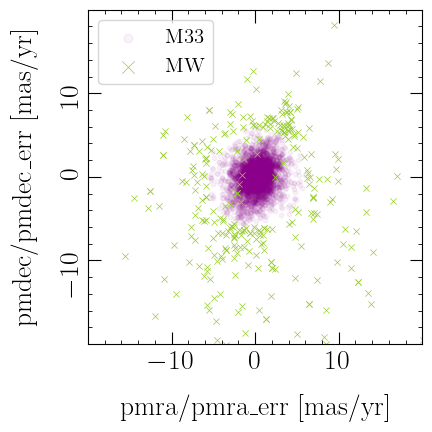

In [767]:
fig, ax2 = plt.subplots(1)
fig.set_size_inches(5,5)
fig.tight_layout()

ax2.set_aspect(1)

ax2.scatter(sg['pmra'][sg_gal]/sg['pmra_error'][sg_gal], sg['pmdec'][sg_gal]/sg['pmdec_error'][sg_gal], s=10, c='darkmagenta', alpha=0.05, label='M33')

ax2.scatter(sg1['pmra'][sg_mw]/sg1['pmra_error'][sg_mw], sg1['pmdec'][sg_mw]/sg1['pmdec_error'][sg_mw], 
           s=20, c='yellowgreen', marker='x', linewidth=0.5,
           label='MW')
ax2.legend(fontsize=15, loc=2)

ax2.set_xlabel('pmra/pmra_err [mas/yr]', fontsize=20)
ax2.set_ylabel('pmdec/pmdec_err [mas/yr]', fontsize=20)

ax2.set_xlim(-20,20)
ax2.set_ylim(-20,20)
ax2.set_aspect(1)

ax2.set_xticks([-10, 0, 10])
ax2.set_yticks([-10, 0, 10])

ax2.tick_params(axis='y', labelrotation=90)

#fig.text(0.5, 1., 'M33 Spitzer-Gaia Xmatch', fontsize=30, ha='center');j

plt.savefig('./images/m33_pm_cut.png', bbox_inches='tight')

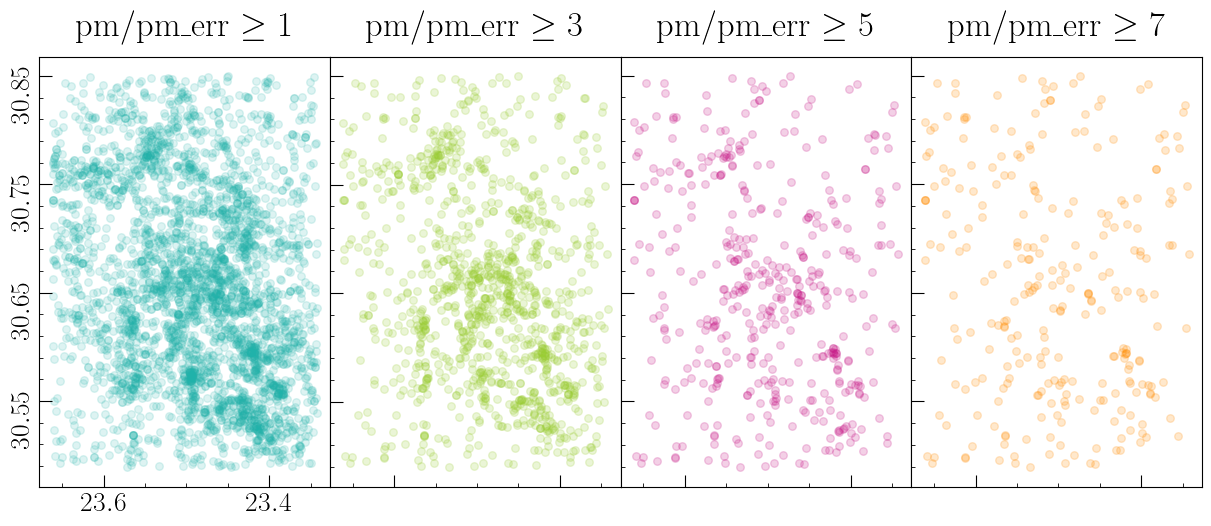

In [768]:
fig, axs = plt.subplots(1,4)
#fig.tight_layout(w_pad=0.1)
fig.set_size_inches(15,10) 
fig.subplots_adjust(wspace=0)

lims = [1, 3, 5, 7, 8, 9, 10]
#cols = ['maroon', 'darkorange', 'yellowgreen', 'cornflowerblue', 'maroon', 'darkorange', 'yellowgreen', 'cornflowerblue']
cols = ['lightseagreen', 'yellowgreen', 'mediumvioletred', 'darkorange', 'tomato', 'darkorchid', 'mediumseagreen', 'royalblue']
alphas = [0.15, 0.2, 0.2, 0.2, 0.3, 0.3]

for i,ax in enumerate(axs.ravel()):
    cut, = np.where((sg['pmra'] / sg['pmra_error'])**2 + (sg['pmdec'] / sg['pmdec_error'])**2 >= (lims[i])**2)
    sg_oth = sg[cut]
    ax.set_aspect(m33_ar)
    plot = ax.scatter(sg_oth['ra'], sg_oth['dec'], 
                    c=cols[i],
                    alpha=alphas[i],
                    s=30)
    ax.invert_xaxis();
    ax.tick_params(which='both', right=False, labelsize=20)
    ax.set_yticks([30.55, 30.65, 30.75, 30.85])
    ax.tick_params(axis='y', labelrotation=90)
    ax.tick_params(which='both', top=False)
    ax.set_title('pm/pm_err $\geq$ ' + str(lims[i]), fontsize=25)
    if i > 0:
        ax.tick_params(labelbottom=False, labelleft=False)
        
plt.savefig('./images/pm_plots.png', bbox_inches='tight')

In [770]:
rm_spitz = np.unique(sg_other['spitzer_phatter_ftprnt_oid'].value)

In [771]:
spitzer.remove_rows(rm_spitz)

In [772]:
#Add an index to more easily reference specific sources
spitzer['index'] = np.arange(0, len(spitzer), 1)

In [773]:
#Spitzer 3.6 band flux convertsion from Reach et al, 2005
#Absolute Calibration of the Infrared Array...
#Gives the conversion to magnitude as m = 2.5log10(F_0/F_d)
#where F_d is the measured flux density and F_0 is the zero point
#The resulting zero‐magnitude flux densities are 280.9 ± 4.1, 179.7 ± 2.6, 115.0 ± 1.7, and 64.13 ± 0.94 Jy in the [3.6], [4.5], [5.8], and [8] μm
#seems to be 7.17 Jy for 24
#
#flux density - 280.9 +/- 4.1 for the 3.6 band

#F_d = 280.9(+-4.1)*10**(m/2.5)

def spitzer_36mag_to_fd(mag):
    #gives flux density
    fd = 280.9 * 10**(-mag / 2.5)
    return fd

def spitzer_45mag_to_fd(mag):
    #gives flux density
    fd = 179.7 * 10**(-mag / 2.5)
    return fd

def spitzer_58mag_to_fd(mag):
    #gives flux density
    fd = 115.0 * 10**(-mag / 2.5)
    return fd

def spitzer_80mag_to_fd(mag):
    #gives flux density
    fd = 64.13 * 10**(-mag / 2.5)
    return fd

def spitzer_24mag_to_fd(mag):
    #gives flux density
    fd = 7.17 * 10**(-mag / 2.5)
    return fd

# Color Conversion

In [774]:
#import the SAGE catalog - cut at 4 < 3.6mag < 11 and
#matched to gaia using their database xmatch capability
sage = vaex.open('./xmatch_sage_gaia.csv')

In [775]:
sage.head(2)

#    separation    sage_oid    c  sstisagema             raj2000    dej2000    jmag    e_jmag       q_jmag    hmag    e_hmag       q_hmag    col__3_6_    e__3_6_    q__3_6_    col__4_5_    e__4_5_    q__4_5_    col__5_8_    e__5_8_    q__5_8_    col__8_0_    e__8_0_    q__8_0_    snj    snh    sn3_6    sn4_5    sn5_8    sn8_0    solution_id  designation                     source_id    random_index    ref_epoch       ra    ra_error       dec    dec_error    parallax    parallax_error    parallax_over_error       pm     pmra    pmra_error    pmdec    pmdec_error    ra_dec_corr    ra_parallax_corr    ra_pmra_corr    ra_pmdec_corr    dec_parallax_corr    dec_pmra_corr    dec_pmdec_corr    parallax_pmra_corr    parallax_pmdec_corr    pmra_pmdec_corr    astrometric_n_obs_al    astrometric_n_obs_ac    astrometric_n_good_obs_al    astrometric_n_bad_obs_al    astrometric_gof_al    astrometric_chi2_al    astrometric_excess_noise    astrometric_excess_noise_sig    astrometric_params_solved  astrometric_primary_flag      nu_eff_used_in_astrometry    pseudocolour    pseudocolour_error    ra_pseudocolour_corr    dec_pseudocolour_corr    parallax_pseudocolour_corr    pmra_pseudocolour_corr    pmdec_pseudocolour_corr    astrometric_matched_transits    visibility_periods_used    astrometric_sigma5d_max    matched_transits    new_matched_transits    matched_transits_removed    ipd_gof_harmonic_amplitude    ipd_gof_harmonic_phase    ipd_frac_multi_peak    ipd_frac_odd_win      ruwe    scan_direction_strength_k1    scan_direction_strength_k2    scan_direction_strength_k3    scan_direction_strength_k4    scan_direction_mean_k1    scan_direction_mean_k2    scan_direction_mean_k3    scan_direction_mean_k4  duplicated_source      phot_g_n_obs    phot_g_mean_flux    phot_g_mean_flux_error    phot_g_mean_flux_over_error    phot_g_mean_mag    phot_bp_n_obs    phot_bp_mean_flux    phot_bp_mean_flux_error    phot_bp_mean_flux_over_error    phot_bp_mean_mag    phot_rp_n_obs    phot_rp_mean_flux    phot_rp_mean_flux_error    phot_rp_mean_flux_over_error    phot_rp_mean_mag    phot_bp_rp_excess_factor    phot_bp_n_contaminated_transits    phot_bp_n_blended_transits    phot_rp_n_contaminated_transits    phot_rp_n_blended_transits    phot_proc_mode    bp_rp      bp_g      g_rp    radial_velocity    radial_velocity_error    rv_method_used    rv_nb_transits    rv_nb_deblended_transits    rv_visibility_periods_used    rv_expected_sig_to_noise    rv_renormalised_gof    rv_chisq_pvalue    rv_time_duration    rv_amplitude_robust    rv_template_teff    rv_template_logg    rv_template_fe_h    rv_atm_param_origin    vbroad    vbroad_error    vbroad_nb_transits    grvs_mag    grvs_mag_error    grvs_mag_nb_transits    rvs_spec_sig_to_noise  phot_variable_flag          l         b    ecl_lon    ecl_lat  in_qso_candidates    in_galaxy_candidates      non_single_star  has_xp_continuous    has_xp_sampled    has_rvs    has_epoch_photometry    has_epoch_rv    has_mcmc_gspphot    has_mcmc_msc    in_andromeda_survey      classprob_dsc_combmod_quasar    classprob_dsc_combmod_galaxy    classprob_dsc_combmod_star    teff_gspphot    teff_gspphot_lower    teff_gspphot_upper    logg_gspphot    logg_gspphot_lower    logg_gspphot_upper    mh_gspphot    mh_gspphot_lower    mh_gspphot_upper    distance_gspphot    distance_gspphot_lower    distance_gspphot_upper    azero_gspphot    azero_gspphot_lower    azero_gspphot_upper    ag_gspphot    ag_gspphot_lower    ag_gspphot_upper    ebpminrp_gspphot    ebpminrp_gspphot_lower    ebpminrp_gspphot_upper  libname_gspphot
  0   0.000114445           1    1  J022608.23-753512.3    36.5343   -75.5868  11.241     0.024  2.93601e+07  10.952     0.024  2.93601e+07       10.82       0.04       16384       10.864      0.034      16384       10.789      0.036          0       10.603      0.108        512  45.24  45.24    27.22    32.18    30.27    10.06    1.63615e+18  Gaia DR3 4634185256147360384  4.63419e+18     7.89517e+08         2016  36.5348   0.01

In [776]:
len(sage), len(sage1[lmc_only])

(27600, 6899993)

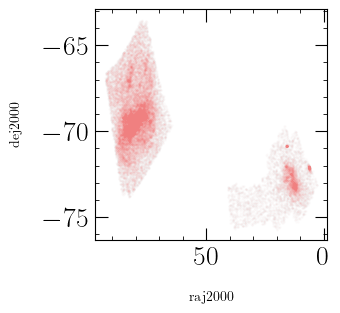

In [777]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,3)
ax.set_xlabel('raj2000', fontsize=10)
ax.set_ylabel('dej2000', fontsize=10)
ax.scatter(sage.raj2000.evaluate(), sage.dej2000.evaluate(), s=1, alpha=0.02)
ax.invert_xaxis();

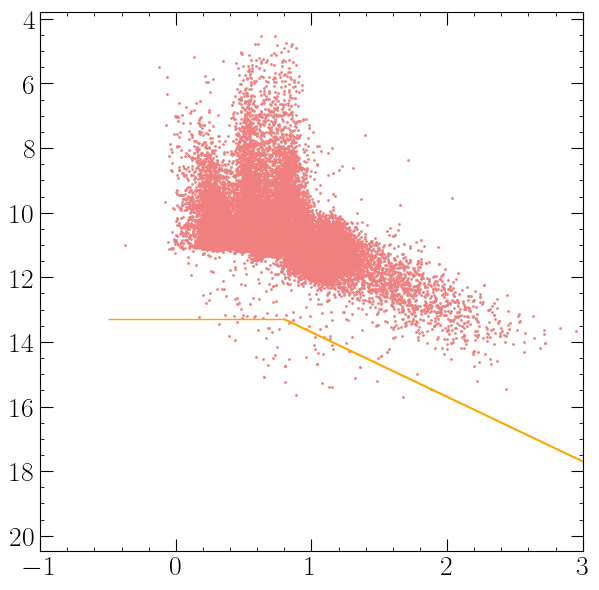

In [778]:
fig, ax = plt.subplots(1)

ax.scatter(sage.jmag.evaluate() - sage.hmag.evaluate(), sage.hmag.evaluate(), 
          s=1);

ax.hlines(13.3, -0.5, 0.8, color='orange', linestyle='-', linewidth=1)

def lmc_goldman_line(x):
    y = (2*x) + 11.7
    return y

lmc_goldx = np.linspace(0.8, 4, 1000)
lmc_goldy = lmc_goldman_line(lmc_goldx)
ax.plot(lmc_goldx, lmc_goldy, color='orange')

ax.set_xlim(-1,3)
ax.invert_yaxis();

In [779]:
#select sources in LMC only, filter out rows with nan for necessary data,
#with px/px_err <= 5 per Gaia collab 2021 - Structure and properties of the Magellanic Clouds
#with mag cut similar to Goldman paper, corrected for LMC TRGB
#13.3, y = (2*x) + 10.9 cut at 1.2
sage.select('(raj2000 > 50) &'
            '(jmag == jmag) & (hmag == hmag) & (col__3_6_ == col__3_6_) & '
            '(phot_g_mean_mag == phot_g_mean_mag) & (bp_rp == bp_rp) & '
            '(pm == pm) & (parallax_over_error <= 5) & '
            '(((jmag - hmag <= 0.8) & (hmag < 13.3)) | ((jmag - hmag > 0.8) & (hmag <= 2*(jmag - hmag) + 11.7)))',
            name='clean')

In [780]:
#convert bp_rp to j_h using published transformation and then look at the ones that make sense

In [781]:
sage_pmra = sage.pmra.evaluate(selection='clean')
pmra_error = sage.pmra_error.evaluate(selection='clean')
sage_pmdec = sage.pmdec.evaluate(selection='clean')
pmdec_error = sage.pmdec_error.evaluate(selection='clean')
pm = sage.pm.evaluate(selection='clean')

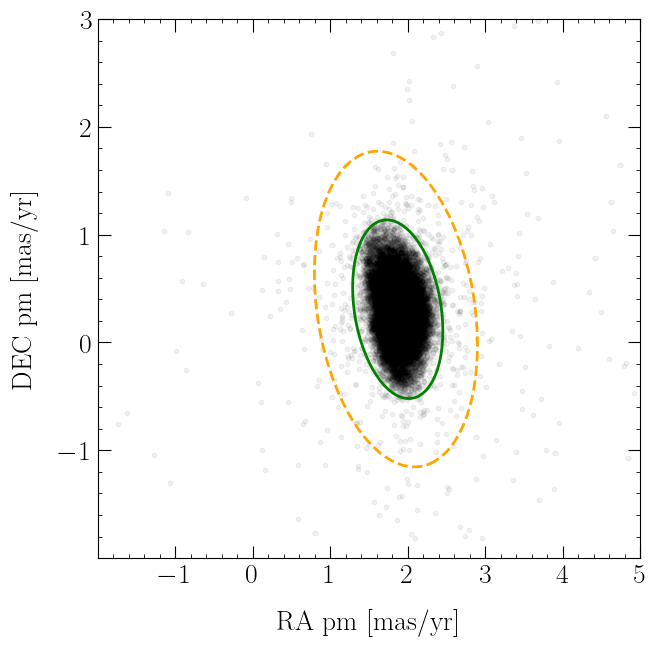

In [782]:
fig, ax = plt.subplots(1)
fig.set_size_inches(7,7)

ax.scatter(sage_pmra, sage_pmdec,
           s=10, 
           color='black', 
           alpha=0.05
          )

ax.set_xlim(-2,5)
ax.set_ylim(-2,3)
ax.set_xticks([ -1, 0, 1, 2, 3, 4, 5])
ax.set_yticks([-1, 0, 1, 2, 3])

ax.set_xlabel('RA pm [mas/yr]', fontsize=20)
ax.set_ylabel('DEC pm [mas/yr]', fontsize=20)

full_patch = mpl.patches.Ellipse((1.85, 0.31), width=2, height=3, angle=17, 
                                 edgecolor='orange', facecolor='none', 
                                 linestyle='--', linewidth=2)

full_path = full_patch.get_path()
full_transform = full_patch.get_patch_transform()
lmc_full_path = full_transform.transform_path(full_path)
sage_pmra, sage_pmdec = sage.pmra.evaluate(selection='clean'), sage.pmdec.evaluate(selection='clean')
lmc_points = np.stack([sage_pmra, sage_pmdec], axis=1)
lmc_full, = np.where(lmc_full_path.contains_points(lmc_points))
medx, medy = np.mean(sage_pmra[lmc_full]), np.mean(sage_pmdec[lmc_full])


pm_patch = mpl.patches.Ellipse((medx, medy), width=1.1, height=1.7, angle=17, 
                              edgecolor='green', facecolor='none', 
                              linewidth=2)

ax.add_patch(pm_patch);
ax.add_patch(full_patch);

plt.savefig('./images/lmc_pm_plot.png', bbox_inches='tight')

In [783]:
pm_path = pm_patch.get_path()
pm_transform = pm_patch.get_patch_transform()
lmc_pm_path = pm_transform.transform_path(pm_path)
lmc_pms, = np.where(lmc_pm_path.contains_points(lmc_points))

In [784]:
jmag = sage.jmag.evaluate(selection='clean')[lmc_pms]
hmag = sage.hmag.evaluate(selection='clean')[lmc_pms] 
_36mag = sage.col__3_6_.evaluate(selection='clean')[lmc_pms]
_45mag = sage.col__4_5_.evaluate(selection='clean')[lmc_pms]
gmag = sage.phot_g_mean_mag.evaluate(selection='clean')[lmc_pms] 
bprp = sage.bp_rp.evaluate(selection='clean')[lmc_pms]
jh = jmag - hmag
h36 = hmag - _36mag
_3645 = _36mag - _45mag

sage_ra, sage_dec = sage.ra.evaluate(selection='clean')[lmc_pms], sage.dec.evaluate(selection='clean')[lmc_pms]

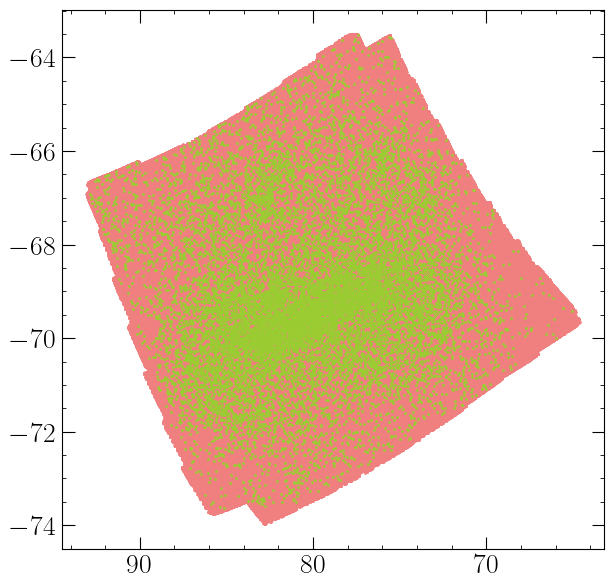

In [785]:
fig, ax = plt.subplots(1)

ax.scatter(sage1['RAJ2000'][lmc_only], sage1['DEJ2000'][lmc_only], s=1)
ax.scatter(sage_ra, sage_dec, s=1)

ax.invert_xaxis();

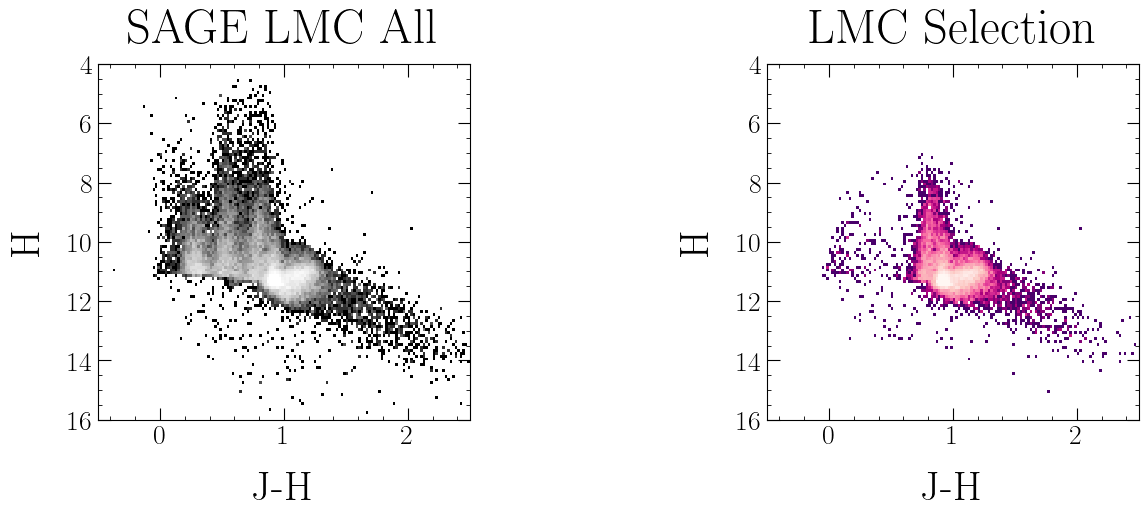

In [786]:
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.tight_layout(w_pad=5)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [150, 120]
            
cmap1 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap1.set_under('w')

ax.hist2d(sage.jmag.evaluate() - sage.hmag.evaluate(), sage.hmag.evaluate(),
          bins=cmd_bins, range=cmd_range, 
          norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2), cmap=cmap1)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(4,16)
ax.invert_yaxis()
ax.set_title('SAGE LMC All')
ax.set_xlabel('J-H')
ax.set_ylabel('H')

cmap2 = copy.copy(mpl.cm.get_cmap('RdPu_r'))
cmap2.set_under('w')
ax2.hist2d(jh, hmag,  
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2),
           bins=cmd_bins, range=cmd_range)


ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(4,16)
ax2.invert_yaxis()
ax2.set_title('LMC Selection')
ax2.set_xlabel('J-H')
ax2.set_ylabel('H');

plt.savefig('./images/lmc_cmds.png', bbox_inches='tight')

In [787]:
vh = [
    (0.83, 11.5), #bottom right
    (0.68, 11.5), #bottom left
    (0.77, 6.5), #top left
    (0.91, 6.5), #top right
    (0.83, 11.5)
]

vg = [
    (1.0, 10.78), #bottom right 
    (0.83, 11.08), #bottom left
    (0.89, 7.5), #top left
    (1.01, 7.5), #top right
    (1.0, 10.8)
]

vj = [(1.0, 12.25), 
      (1.0, 9.6), 
      (1.31, 10.0), 
      (1.31, 12.6), 
      (1.0, 12.25)
    
]

vk = [(1.31, 9.5), 
      (2.5, 12), 
      (2.5, 15.5), 
      (1.31, 13.15), 
      (1.31, 9.5)
    
]

vf = [(0.8, 12.3), #bottom left
      (0.84, 11.04), #top left
      (1.0, 10.74), #top right
      (1.0, 12.25), #bottom right
      (0.83, 12.25)
    
]

vc = [(0.47, 13.5), #bottom left
      (0.4, 5.0), 
      (0.8, 5.0),
      (0.68, 11.5),
      (0.61, 11.5), #corner
      (0.61, 13.5), #bottom right
      (0.47, 13.5)
    
]

vb = [(0.47, 13.5), 
      (0.4, 5.5), 
      (0.04, 5.5), 
      (0.25, 13.5), 
      (0.47, 13.5)
    
]

vi = [(0.61, 13.5), #bottom left
      (0.61, 11.5), #top left
      (0.83, 11.5), #top right
      (0.8, 12.3),
      (0.65, 13.5), #bottom right
      (0.61, 13.5)
    
]

ve = [(0.65, 13.5), 
      (0.8, 12.3), 
      (1.0, 12.25), 
      (1.0, 13.5),
      (0.65, 13.5)
    
]

codes_4 = [
    Path.MOVETO, 
    Path.LINETO, 
    Path.LINETO, 
    Path.LINETO, 
    Path.CLOSEPOLY
]

codes_5 = [Path.MOVETO,
                        Path.LINETO,
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.CLOSEPOLY
                        ]

codes_6 = [Path.MOVETO,
                        Path.LINETO,
                        Path.LINETO,
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.CLOSEPOLY
                        ]

verts = [vb, vc, vh, vi, ve, vf, vg,  vj, vk]
codes = [codes_4, codes_6, codes_4, codes_5, codes_4, codes_4, codes_4, codes_4, codes_4]

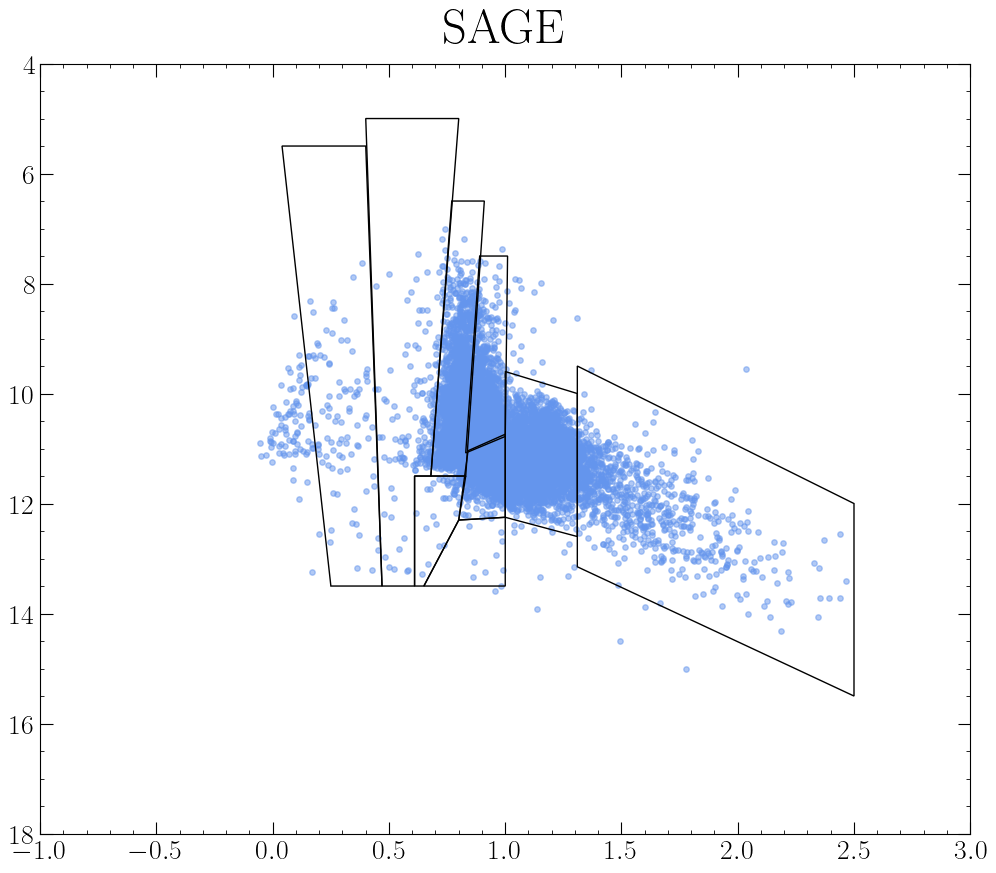

In [788]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)

ax.scatter(jh, hmag, c='cornflowerblue', s=15, alpha=0.5)

ax.set_xlim(-1,3)
ax.set_ylim(4,18)
ax.invert_yaxis()
ax.set_title('SAGE')

for i,v in enumerate(verts):
    path = Path(v, codes[i])
    patch = patches.PathPatch(path, facecolor='none', edgecolor='black', linewidth=1)
    ax.add_patch(patch)

In [789]:
pts_jh = np.stack((jh, hmag), axis=1)

In [790]:
vals = np.full_like(jh, 11)
blue_giants, = np.where(jh < 0.3)
vals[blue_giants] = 0

for i,vert in enumerate(verts):
     path = Path(vert, codes[i])
     inpts, = np.where(path.contains_points(pts_jh))
     vals[inpts] = i + 1
     #cols[inpts] = colors[i]

In [791]:
#paths for figure only!!!
#edges do not overlap and leave out some points

vbf = [(0.45, 13.5), #bottom right
      (0.38, 5.5), #top right
      (0.04, 5.5), #top left
      (0.25, 13.5), #bottom left
      (0.47, 13.5)
    
]

vcf = [(0.46, 13.5), #bottom left
      (0.4, 5.0), #top left
      (0.77, 5.0), #top right
      (0.66, 11.48), #mid right
      (0.59, 11.48), #corner
      (0.59, 13.5), #bottom right
      (0.47, 13.5)
    
]

vhf = [
    (0.81, 11.48), #bottom right
    (0.68, 11.48), #bottom left
    (0.77, 6.5), #top left
    (0.89, 6.5), #top right
    (0.83, 11.5)
]

vif = [(0.61, 13.5), #bottom left
      (0.61, 11.53), #top left
      (0.81, 11.53), #top right
      (0.78, 12.3),
      (0.63, 13.5), #bottom right
      (0.61, 13.5)
    
]

vgf = [
    (0.98, 10.78),#bottom right 
    (0.84, 11.08), #bottom left
    (0.90, 7.5), #top left
    (0.99, 7.5), #top right
    (1.0, 10.8)
]

vff = [(0.8, 12.28), #bottom left
      (0.84, 11.11), #top left
      (0.98, 10.81), #top right
      (0.98, 12.23), #bottom right
      (0.83, 12.25)
    
]

vef = [(0.65, 13.5), #bottom left
      (0.8, 12.34), #top left
      (0.98, 12.29), #top right
      (0.98, 13.5), #bottom right
      (0.65, 13.5)
    
]

vjf = [(1.0, 12.25), #bottom left
      (1.0, 9.6), #top left
      (1.29, 9.96), #top right
      (1.29, 12.56), #bottom right
      (1.0, 12.25)
    
]

vkf = [(1.31, 9.5), 
      (2.5, 12), 
      (2.5, 15.5), 
      (1.31, 13.15), 
      (1.31, 9.5)
    
]











codes_4 = [
    Path.MOVETO, 
    Path.LINETO, 
    Path.LINETO, 
    Path.LINETO, 
    Path.CLOSEPOLY
]

codes_5 = [Path.MOVETO,
                        Path.LINETO,
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.CLOSEPOLY
                        ]

codes_6 = [Path.MOVETO,
                        Path.LINETO,
                        Path.LINETO,
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.LINETO, 
                        Path.CLOSEPOLY
                        ]

vertsf = [vbf, vcf, vhf, vif, vef, vff, vgf,  vjf, vk]
codes = [codes_4, codes_6, codes_4, codes_5, codes_4, codes_4, codes_4, codes_4, codes_4]

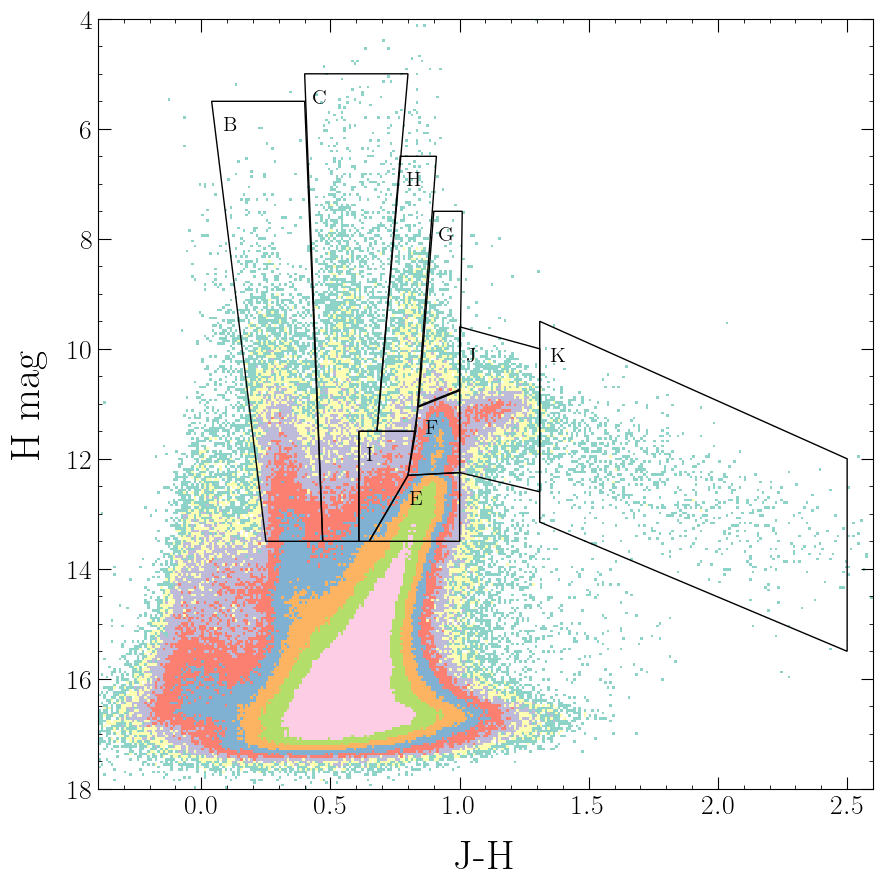

In [792]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

cmap = cm.get_sub_cmap('Set3', 0.0, 0.6)
cmap.set_under('w')

plot = ax.hist2d(sage1['Jmag'][lmc_only] - sage1['Hmag'][lmc_only], sage1['Hmag'][lmc_only], 
          bins=300, range=[[-0.4,2.6], [4,18]],
          cmap=cmap, norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e3))
ax.invert_yaxis()

txt_xs = [0.11, 0.46, 0.82, 0.95, 0.89, 0.65, 0.83, 1.05, 1.38]
txt_ys = [6.1, 5.6, 7.1, 8.1, 11.6, 12.1, 12.9, 10.3, 10.3]
txts = ['B', 'C', 'H', 'G', 'F', 'I', 'E', 'J', 'K']

for i,v in enumerate(verts):
    if v == vg:
        vs = [(1.0, 10.76), #bottom right 
            (0.84, 11.06), #bottom left
            (0.90, 7.5), #top left
            (1.01, 7.5), #top right
            (1.0, 10.8)]
        path = Path(vs, codes[i])
        patch = patches.PathPatch(path, facecolor='none', edgecolor='black', linewidth=1)
        ax.add_patch(patch)
        
    else:
        path = Path(v, codes[i])
        patch = patches.PathPatch(path, facecolor='none', edgecolor='black', linewidth=1)
        ax.add_patch(patch)
        
    ax.text(txt_xs[i], txt_ys[i], txts[i], ha='center', va='bottom', fontsize=15)

#ax.set_title('SAGE - LMC')
ax.set_xlabel('J-H')
ax.set_ylabel('H mag')

#cbar = plt.colorbar(plot[3], ax=ax);

plt.savefig('./images/sage_cmd_regions.png', bbox_inches='tight')

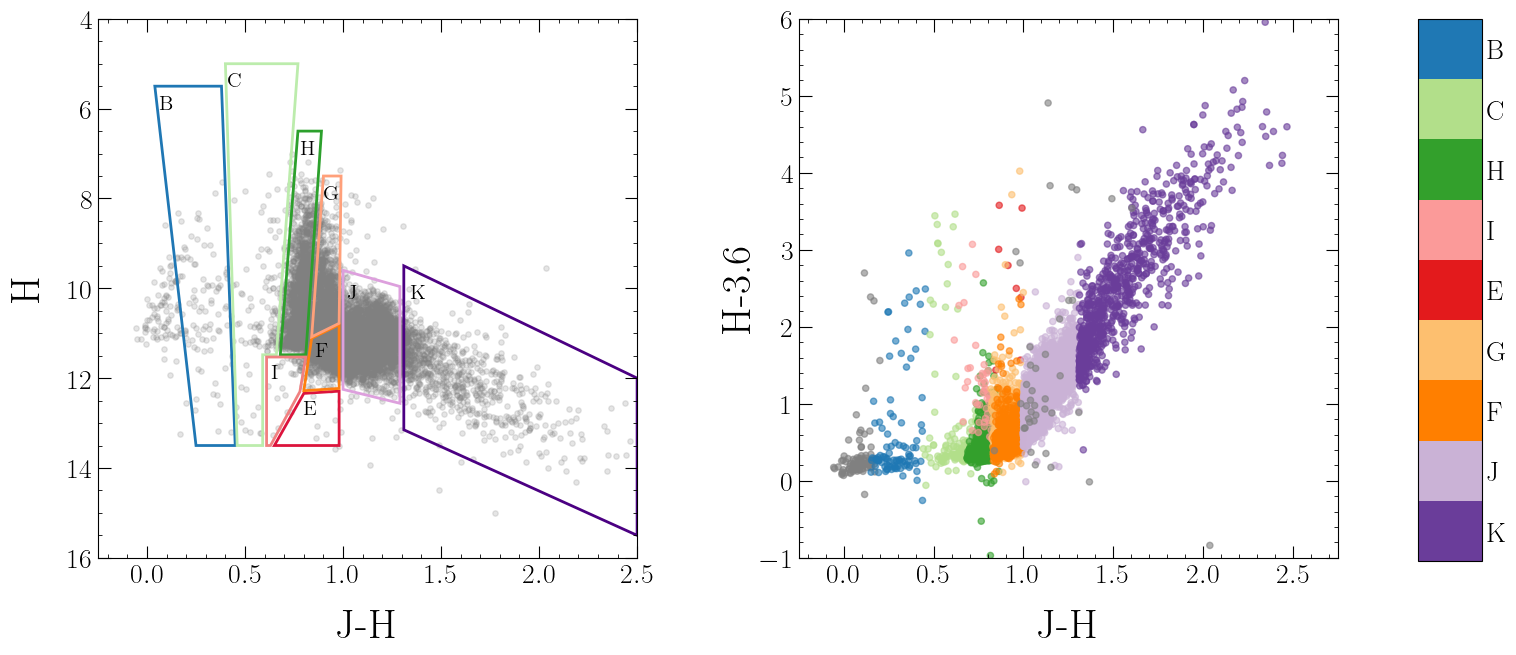

In [793]:
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,7)
fig.subplots_adjust(wspace=0.3)

ax.scatter(jh, hmag, c='grey', s=15, alpha=0.2)

ax.set_xlim(-0.25,2.5)
ax.set_ylim(4,16)
ax.invert_yaxis()

cs = ['tab:blue', 'xkcd:light sage', 'tab:green', 'lightcoral', 'crimson', 'tab:orange', 'lightsalmon', 'plum', 'indigo']
txt_xs = [0.1, 0.45, 0.82, 0.945, 0.89, 0.65, 0.83, 1.05, 1.38]
txt_ys = [6.1, 5.6, 7.1, 8.1, 11.6, 12.1, 12.9, 10.3, 10.3]
txts = ['B', 'C', 'H', 'G', 'F', 'I', 'E', 'J', 'K']

for i,v in enumerate(vertsf):
    path = Path(v, codes[i])
    patch = patches.PathPatch(path, facecolor='none', edgecolor=cs[i], linewidth=2)
    ax.add_patch(patch)
    ax.text(txt_xs[i], txt_ys[i], txts[i], ha='center', va='bottom', fontsize=15)


cmap = cm.get_sub_cmap('Paired', 0.085, 0.83)
cmap.set_over('grey')
cmap.set_under('grey')

ss = np.argsort(vals)
plot = ax2.scatter(jh[ss], h36[ss], c=vals[ss], cmap=cmap, vmin=1, vmax=10, s=20, alpha=0.6
                  )
ax2.set_xlim(-0.25,2.75)
ax2.set_ylim(-1,6)


cax = fig.add_axes([0.95, 0.105, 0.04, 0.775])
cax.invert_yaxis()
cbar = plt.colorbar(plot, cax=cax)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=['B', 'C', 'H', 'I', 'E', 'G', 'F', 'J', 'K']);
cax.tick_params(which='both', length=0)
cbar.solids.set(alpha=1);

ax.set_xlabel('J-H')
ax.set_ylabel('H')
ax2.set_xlabel('J-H')
ax2.set_ylabel('H-3.6', labelpad=1)

#fig.text(0.5, 0.95, 'SAGE - LMC', ha='center',);

plt.savefig('./images/sage_cmd_cloc.png', bbox_inches='tight')

In [794]:
j_as, h_as = sage1['Jmag'][lmc_only], sage1['Hmag'][lmc_only]
jh_as = j_as - h_as

ra_as, dec_as = sage1['RAJ2000'][lmc_only], sage1['DEJ2000'][lmc_only]

In [795]:
all_jh = np.stack((jh_as, h_as), axis=1)

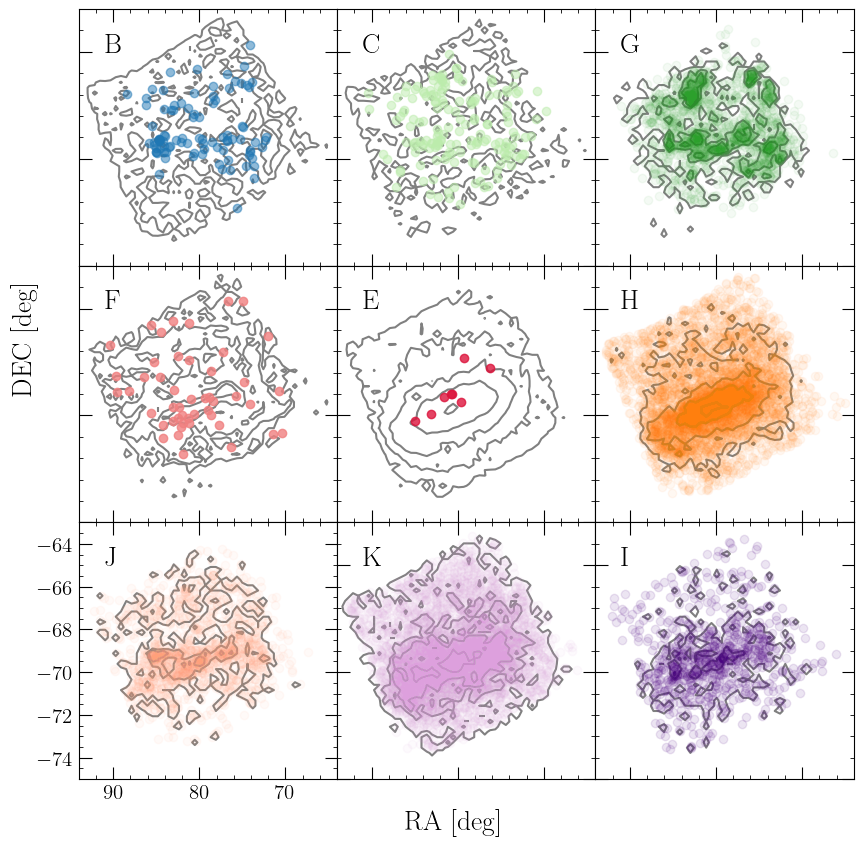

In [796]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace=0, hspace=0)

cs = ['tab:blue', 'xkcd:light sage', 'tab:green', 'lightcoral', 'crimson', 'tab:orange', 'lightsalmon', 'plum', 'indigo']
labels = ['B', 'C', 'G', 'F', 'E', 'H', 'J', 'K', 'I']
alphas = [0.5, 0.5, 0.05, 0.8, 0.8, 0.05, 0.05, 0.05, 0.1]
levels = [[15, 25], [10, 25, 50], [1, 5, 10], 
          [5, 10, 25, 50], [25, 50, 100, 200, 500], [10, 25, 50, 100], 
          [1, 5, 10], [1, 5, 10, 25], [1, 5, 10, 25]]


for i,ax in enumerate(axs.ravel()):
    path = Path(verts[i], codes[i])
    inpts, = np.where(path.contains_points(all_jh))
    incl, = np.where(vals == i + 1)
    
    sage_hist = np.histogram2d(ra_as[inpts], dec_as[inpts], 
                           bins=50, 
                           range=[[64, 94], [-75, -63]])

    Z = sage_hist[0].T
    X,Y = np.meshgrid(np.linspace(64, 94, 50), np.linspace(-75, -63, 50))
    
    ax.contour(X, Y, Z, levels=levels[i], colors='grey')
    ax.scatter(sage_ra[incl], sage_dec[incl], c=cs[i], alpha=alphas[i], zorder=10)
    ax.set_xlim(64, 94)
    ax.set_ylim(-75, -63)
    ax.invert_xaxis()
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.text(91, -65, labels[i], fontsize=20);
    
axs[2,0].tick_params(axis='both', labelsize=15, labelbottom=True, labelleft=True)

fig.text(0.5, 0.06, 'RA [deg]', fontsize=20, ha='center')
fig.text(0.07, 0.5, 'DEC [deg]', fontsize=20, rotation=90, ha='center');

plt.savefig('./images/lmc_contour_maps.png', bbox_inches='tight')

In [797]:
bins = 52

lmc_colcol = np.histogram2d(jh, h36, bins=[bins*2, bins], range=[[-0.1, 2.5], [-0.5, 5.5]])

#list of median, mean, & std of hw1 values of a given slice
running_median = []
running_mean = []
running_std = []
#index values that have a usable mean
nz = []
#how many data points contribute to each median
wts = []
for i in range(bins*2):
    #finds the hw1 values for a given one-bin-width-slice of jh
    window = h36[np.where((jh >= lmc_colcol[1][i]) 
                            & (jh < lmc_colcol[1][i+1]))]
    ws = window.size
    if ws > 2:
        median = np.median(window)
        mean = np.mean(window)
        std = np.std(window)
        
        running_median.append(median)
        running_mean.append(mean)
        running_std.append(std)
        nz.append(i)
        wts.append(ws)

running_median = np.array(running_median)
running_mean = np.array(running_mean)
running_std = np.array(running_std)
wts = np.array(wts)

In [913]:
#fit both regions of col-col with linear regression
xs = lmc_colcol[1][:-1][nz]
line1, = np.where(xs < 0.95)
line2, = np.where(xs > 0.85)

fit1 = stats.linregress((xs[line1], running_median[line1]))
fit2 = stats.linregress((xs[line2], running_median[line2]))

In [914]:
len(xs), len(running_median), len(lmc_colcol[1])

(90, 90, 105)

In [915]:
def jh36_blue(jh):
    h36 = fit1.intercept + fit1.slope * jh
    return h36

def jh36_red(jh):
    h36 = fit2.intercept + fit2.slope * jh
    return h36

In [916]:
fit1.intercept, fit1.slope, fit2.intercept, fit2.slope

(0.24752537541151395,
 0.2937326944328027,
 -2.2812200293602944,
 3.1170047641493044)

In [917]:
def find_intercept(rnd=2):
    x = (fit2.intercept - fit1.intercept) / (fit1.slope - fit2.slope)
    y = fit1.slope*x + fit1.intercept
    return x.round(rnd), y.round(rnd)

In [918]:
xx = np.linspace(-0.5,2.5,1000)

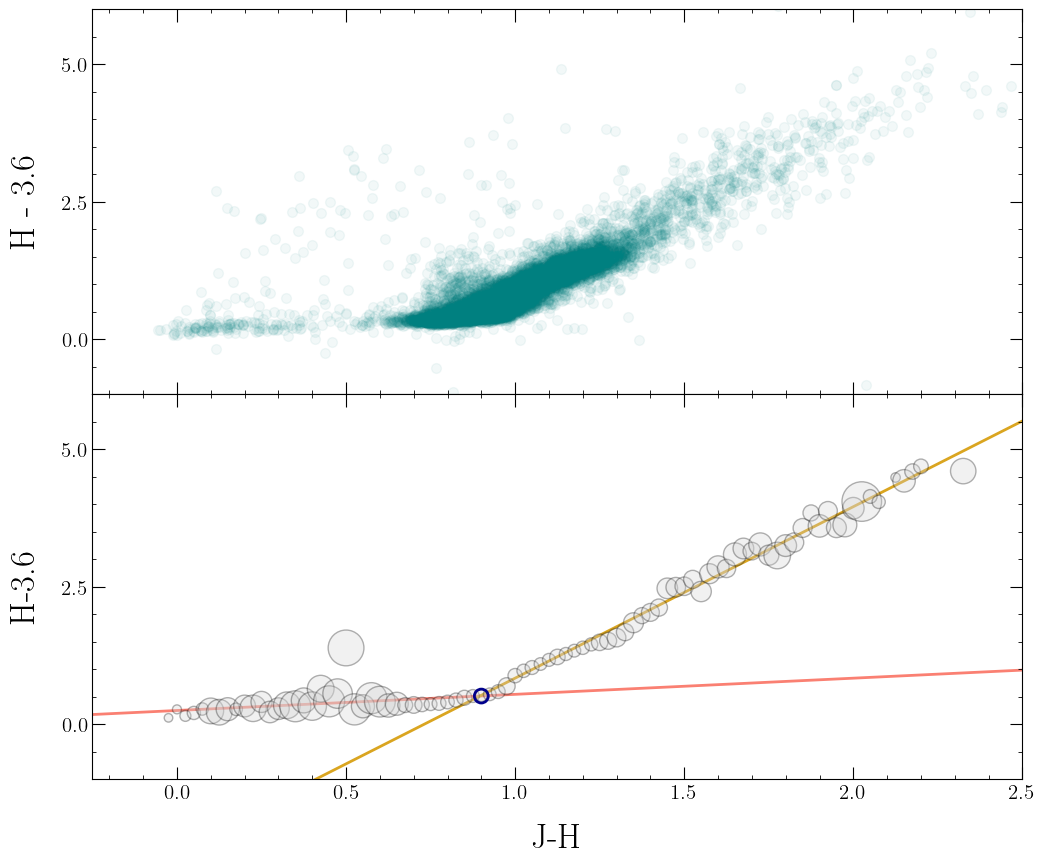

In [920]:
fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(12,10)
fig.subplots_adjust(hspace=0)

ax.scatter(jh, h36, c='teal', marker='o', s=50, alpha=0.05)

ax.set_xlim(-0.25,2.5)
ax.set_ylim(-1,6);

ax.set_ylabel('H - 3.6', fontsize=25)

ax.tick_params(axis='both', labelsize=15, labelbottom=False)
ax.set_yticks([0, 2.5, 5])


ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-1,6)
ax2.set_xlabel('J-H', fontsize=25)
ax2.set_ylabel('H-3.6', fontsize=25)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_yticks([0, 2.5, 5])


ax2.plot(xx, fit1.intercept + fit1.slope * xx, linewidth=2, linestyle='-', c='salmon')
ax2.plot(xx, fit2.intercept + fit2.slope * xx, linewidth=2, linestyle='-', c='goldenrod')
ax2.scatter(xs, running_median,  
             marker='o',
             edgecolor='black', facecolor='lightgrey', 
             alpha=0.3, 
             s=running_std*500, 
             linewidth=1, label='Medians', 
             zorder=10
            );

x_intercept = 0.91
ax2.scatter(find_intercept()[0], find_intercept()[1], edgecolor='darkblue', facecolor='none', lw=2, s=100, zorder=10)

plt.savefig('./images/lmc_cloc_fits.png', bbox_inches='tight')

In [921]:
find_intercept()[0], find_intercept()[1]

(0.9, 0.51)

In [922]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [923]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [924]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 3, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [925]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

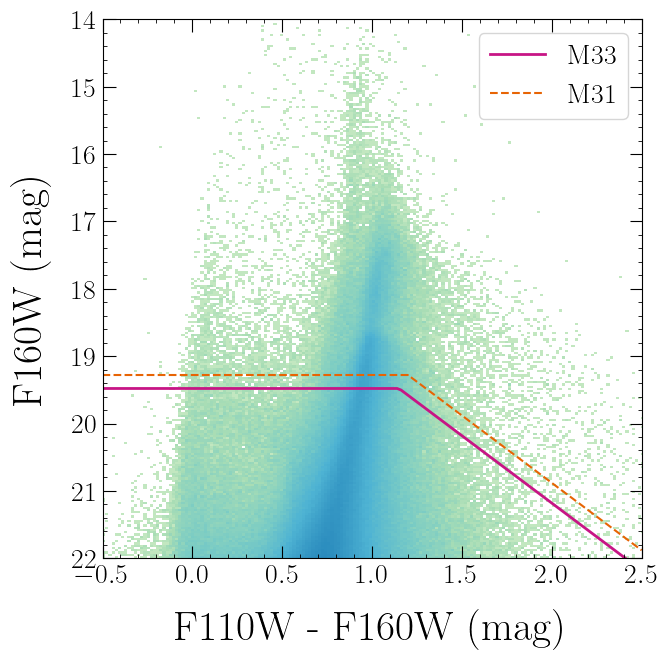

In [926]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(), phatter.F160W_VEGA.evaluate(),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('./images/goldman_cut.png', bbox_inches='tight')

In [927]:
hst_transforms = ascii.read('./synphot_data.csv')

## j=1235, h=1660

In [928]:
hst_transforms[:3]

<Table length=3>
Library     Filename     Simbad_ID   F110W   F160W  ... spectral_type   Teff    logg    FeH  
  str7       str32         str30    float64 float64 ...     str21     float64 float64 float64
------- --------------- ----------- ------- ------- ... ------------- ------- ------- -------
CALSPEC 109vir_stis_003   * 109 Vir  0.5951     0.6 ...       A0IIInn 11000.0     4.2    -0.2
CALSPEC  10lac_stis_007   *  10 Lac -2.9862 -2.8822 ...           O9V 35200.0    3.89      --
CALSPEC 16cygb_stis_003 *  16 Cyg B   3.517   3.109 ...           G3V  5776.0    4.28    0.06

In [929]:
rrr,  = np.where(hst_transforms['F110W'] - hst_transforms['F160W']> 2)
hst_transforms[rrr]

<Table length=2>
Library        Filename        Simbad_ID   F110W  ... spectral_type   Teff    logg    FeH  
  str7          str32            str30    float64 ...     str21     float64 float64 float64
------- ---------------------- ---------- ------- ... ------------- ------- ------- -------
   IRTF   M8III_IRAS01037+1219 IRC +10011 -0.9537 ...            M8      --      --      --
   IRTF M10+III_IRAS14086-0703 RAFGL 1686 -2.7425 ...         M9III      --      --      --

In [930]:
np.where(hst_transforms['object_type'] == 'MS*')

(array([942]),)

In [931]:
hst_transforms['object_num'] = [0] * len(hst_transforms)

In [932]:
s_types = ['OH*', 'S*', 'LP*', 'AB*', 'C*', 'Mi*']
s_names = ['OH', 'S', 'LPV', 'AGB', 'Carbon', 'Mira']

In [933]:
for i,star in enumerate(s_types):
    objs, = np.where(hst_transforms['object_type'] == star)
    hst_transforms['object_num'][objs] = i + 1

In [934]:
tt_ff, tt_jh, tt_hk, tt_110j, tt_160h = hst_transforms['F110W'] - hst_transforms['F160W'], hst_transforms['J'] - hst_transforms['H'], hst_transforms['H'] - hst_transforms['K'], hst_transforms['F110W'] - hst_transforms['J'], hst_transforms['F160W'] - hst_transforms['H']
tt_160k = hst_transforms['F160W'] - hst_transforms['K']

tt_110, tt_160 = hst_transforms['F110W'], hst_transforms['F160W']

In [935]:
oth, = np.where(hst_transforms['object_num'] == 0)
styp, = np.where(hst_transforms['object_num'] != 0)

In [936]:
tt_xs = np.linspace(-0.2, 2.6, 100)

In [937]:
np.max(tt_ff)

2.5385

In [938]:
carbon_fit, = np.where((hst_transforms['object_type'] == 'C*') & (tt_ff > 1.25))

In [939]:
xc, ycj, ych = tt_ff[carbon_fit], tt_110j[carbon_fit], tt_160h[carbon_fit]
cfit_j = stats.linregress((xc, ycj))
cfit_h = stats.linregress((xc, ych))

In [940]:
cfm_j, cfb_j = cfit_j.slope, cfit_j.intercept
cfm_h, cfb_h = cfit_h.slope, cfit_h.intercept

In [941]:
#fake data by fitting line to JUST the several red carbon stars
#use this line to generate 100 points of data between 1.6 < 110-160 < 2.5

clxs = np.linspace(1.6, 2.5, 100)
clys_j = clxs*cfm_j + cfb_j
clys_h = clxs*cfm_h + cfb_h

cj_line = tt_xs*cfm_j + cfb_j
ch_line = tt_xs*cfm_h + cfb_h

In [942]:
def f110160_to_110j(f110, f160):
    _110j = to110_fit.slope * (f110 - f160) + to110_fit.intercept
    return _110j

def f110160_to_160h(f110, f160):
    _160h = to110_fit.slope * (f110 - f160) + to110_fit.intercept
    #_160h2 = 0.5 + 0.01*(f110 - f160)
    return _160h

def get_jh(f110, f160):
    j = f110 - f110160_to_110j(f110, f160)
    opt1 = f110160_to_160h(f110, f160)
    h = f160 - opt1
    #h2 = f160 - opt2
    return j,h

In [943]:
full_x = np.concatenate((tt_ff.value, clxs))
ss = np.argsort(full_x)

full_110j = np.concatenate((tt_110j, clys_j))[ss]
full_160h = np.concatenate((tt_160h, clys_h))[ss]

In [944]:
spline_110j = spline(full_x[ss], full_110j)
spline_160h = spline(full_x[ss], full_160h)

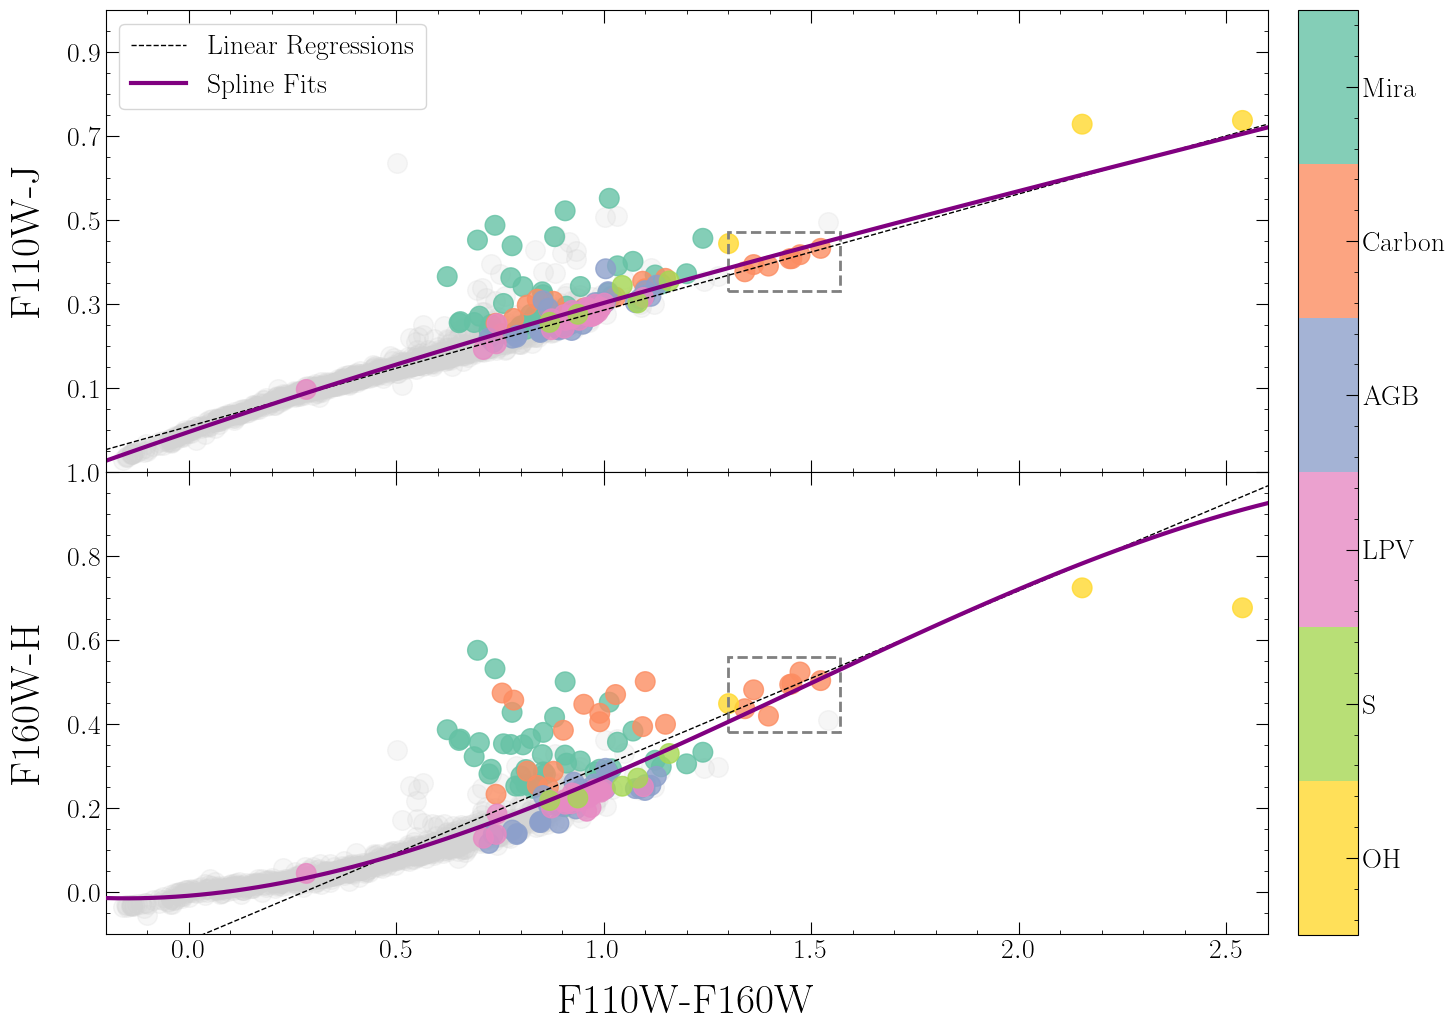

In [945]:
fig, ([ax3, ax4]) = plt.subplots(2,1)
fig.set_size_inches(15,12)
fig.subplots_adjust(hspace=0)


ax3.scatter(tt_ff[oth], tt_110j[oth], c='lightgrey', s=200, alpha=0.2)
ss = np.argsort(hst_transforms['object_num'][styp])[::-1]
plot = ax3.scatter(tt_ff[styp][ss], tt_110j[styp][ss], s=200, 
            alpha=0.8, 
            c=hst_transforms['object_num'][styp][ss], 
            cmap=cm.get_sub_cmap('Set2_r', 0.25, 1.0), 
                   vmin=1, vmax=7
           )
ax3.plot(tt_xs, cj_line, linestyle='--', c='black', linewidth=1, label='Linear Regressions')
ax3.plot(tt_xs, spline_110j(tt_xs), c='purple', linewidth=3, label='Spline Fits')
#cbar = plt.colorbar(plot, ax=ax3)
#cbar.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
#cbar.set_ticklabels(s_names)


ax3.set_xlabel('F110W-F160W')
ax3.set_ylabel('F110W-J')
ax3.set_xlim(-0.2, 2.6)
ax3.set_ylim(-0.1, 1.0)
ax3.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])

ax4.scatter(tt_ff[oth], tt_160h[oth], c='lightgrey', s=200, alpha=0.2)
plot2 = ax4.scatter(tt_ff[styp][ss], tt_160h[styp][ss], s=200, 
           alpha=0.8, 
            c=hst_transforms['object_num'][styp][ss], 
            cmap=cm.get_sub_cmap('Set2_r', 0.25, 1.0), 
                   vmin=1, vmax=7
                   )
ax4.plot(tt_xs, ch_line, linestyle='--', c='black', linewidth=1)
ax4.plot(tt_xs, spline_160h(tt_xs), c='purple', linewidth=3, zorder=20)

ax4.set_xlim(-0.2, 2.6)
ax4.set_ylim(-0.1, 1.0)
ax4.set_xlabel('F110W-F160W')
ax4.set_ylabel('F160W-H');

#cbar2 = plt.colorbar(plot2, ax=ax4)
#cbar2.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
#cbar2.set_ticklabels(s_names);

#ax3.scatter(sample_x, sample_110, c='black', marker='x', label='Artificial Data');
#ax4.scatter(sample_x, sample_160, c='black', marker='x');

cax = fig.add_axes([0.92, 0.109, 0.04, 0.771])
cbar = plt.colorbar(plot2, cax)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar.set_ticklabels(s_names);

ax3.legend(loc=2);

rc_box1 = patches.Rectangle((1.3,0.33), 0.27, 0.14, edgecolor='grey', facecolor='none', linestyle='--', linewidth=2)
rc_box2 = patches.Rectangle((1.3, 0.38), 0.27, 0.18, edgecolor='grey', facecolor='none', linestyle='--', linewidth=2)
ax3.add_patch(rc_box1)
ax4.add_patch(rc_box2)

plt.savefig('./images/synth_fits.png', bbox_inches='tight')

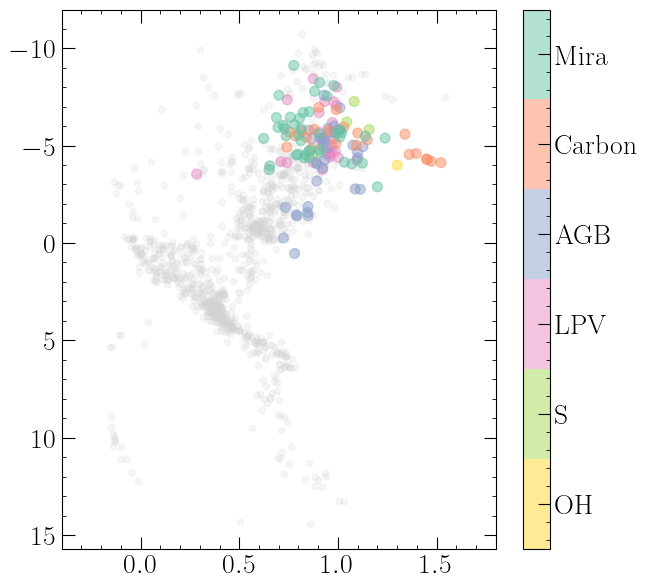

In [946]:
fig, ax = plt.subplots(1)

ax.scatter(tt_ff[oth], tt_110[oth], c='lightgrey', s=20, alpha=0.2)

ss = np.argsort(hst_transforms['object_num'][styp])
plot = ax.scatter(tt_ff[styp][ss], tt_110[styp][ss], c=hst_transforms['object_num'][styp][ss], 
                  s=50, alpha=0.5,
                 cmap=cm.get_sub_cmap('Set2_r', 0.25, 1.0), 
                   vmin=1, vmax=7);
ax.set_xlim(-0.4, 1.8)
ax.invert_yaxis();

cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar.set_ticklabels(s_names);

In [947]:
def get_j(m1, m2):
    _110j = spline_110j(m1 - m2)
    return _110j

def get_h(m1, m2):
    _160h = spline_160h(m1 - m2)
    return _160h

def get_2mass(m1, m2):
    j = m1 - get_j(m1, m2)
    h = m2 - get_h(m1, m2 )
    return j,h

In [948]:
###Define J and H for ph_data sources and add to dataframe
#phatter['J_MAG'], phatter['H_MAG'] =  solve_jh(raw_f110, raw_f160, m3, m_all, b3, b_all)
#phatter['J_H'] = phatter['J_MAG'] - phatter['H_MAG'] 

In [949]:
phatter['J'], phatter['H'] = get_2mass(raw_f110, raw_f160)
phatter['J_H'] = phatter['J'] - phatter['H']
#phatter['J_H_2'] = phatter['J'] - phatter['H2']

In [950]:
np.min(phatter.J_H.evaluate())

-0.39425622300871055

In [951]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022

phatter.select('IR_GST & ' 
               '(J_H >= 0.0) & (J_H <= 2.5) &'
               '(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18)))',
               name='COL_CUT')

In [952]:
cut_110, cut_160 = phatter.F110W_VEGA.evaluate(selection='COL_CUT'), phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [953]:
H_MAG = phatter.H.evaluate(selection='COL_CUT')
#H_MAG2 = phatter.H2.evaluate(selection='COL_CUT')
J_H = phatter.J_H.evaluate(selection='COL_CUT')
#J_H2 = phatter.J_H_2.evaluate(selection='COL_CUT')

In [954]:
###Convert J-H to H-3.6 using regressions from LMC color locus

hh1, = np.where(J_H < x_intercept)
hh2, = np.where(J_H >= x_intercept)
#hh11, = np.where(J_H2 < x_intercept)
#hh22, = np.where(J_H2 >= x_intercept)


H_36 = np.full_like(J_H, 0)
#H2_36 = np.full_like(J_H, 0)

H_36[hh1] = jh36_blue(J_H[hh1])
H_36[hh2] = jh36_red(J_H[hh2])
#H2_36[hh11] = jh36_blue(J_H2[hh11])
#H2_36[hh22] = jh36_red(J_H2[hh22])


MAG_36 = H_MAG - H_36
#MAG_36_2 = H_MAG2 - H2_36

###Convert 3.6 magnitude to flux density
FD_36 = spitzer_36mag_to_fd(MAG_36)
#FD_36_2 = spitzer_36mag_to_fd(MAG_36_2)

In [955]:
filts = ['mag36', 'mag45', 'mag58', 'mag80', 'mag24']
new_cols = ['fd36', 'fd45', 'fd58', 'fd80', 'fd24']
funcs = [spitzer_36mag_to_fd, spitzer_45mag_to_fd, spitzer_58mag_to_fd, spitzer_80mag_to_fd, spitzer_24mag_to_fd]

for i in range(len(filts)):
    spitzer[new_cols[i]] = funcs[i](spitzer[filts[i]])


In [956]:
#index_colcut = phatter.INDEX.evaluate(selection='COL_CUT')

RA,DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')

## Matching Process

In [957]:
search_radius = 2 / 3600

In [958]:
len(spitzer)

18697

In [959]:
###Spitzer RA and DEC
ra_spitz, dec_spitz = np.array(spitzer['ra']), np.array(spitzer['dec'])

In [960]:
rb_min, rb_max = np.min(ra_spitz) - 0.05, np.max(ra_spitz) + 0.05
db_min, db_max = np.min(dec_spitz) - 0.05, np.max(dec_spitz) + 0.05

In [961]:
bins_ra, bins_dec = ceil((rb_max - rb_min) / search_radius), ceil((db_max - db_min) / search_radius)
bins_ra, bins_dec

(748, 825)

In [962]:
ra_bins = np.linspace(rb_min, rb_max, bins_ra)
dec_bins = np.linspace(db_min, db_max, bins_dec)

In [963]:
hist_spitz,hx,hy = np.histogram2d(ra_spitz, dec_spitz, bins=[ra_bins, dec_bins])
bin_nums_spitz = ri.get_indices(hist_spitz, ra_spitz, dec_spitz, x_bins=hx, y_bins=hy)

In [964]:
len(bin_nums_spitz)

18697

In [965]:
hist_phatter,hxx,hyy = np.histogram2d(RA,DEC, bins=[hx,hy])
bin_nums_phatter = ri.get_indices(hist_phatter, RA,DEC, x_bins=hx, y_bins=hy)

In [966]:
hist_gst,_,_ = np.histogram2d(ra_gst, dec_gst, bins=[hx,hy])
indgst =  ri.get_indices(hist_gst, ra_gst, dec_gst, x_bins=hx, y_bins=hy)

In [967]:
spitz_i = 10318
s_bin_num= bin_nums_spitz[spitz_i]
p, = np.where(bin_nums_phatter == s_bin_num)
s_bin_num, p[:5]

(205408, array([96314, 96399]))

In [968]:
same_bins, = np.where((spitzer['ra'] < 23.39050) & (spitzer['ra'] > 23.38875) & (spitzer['dec'] > 30.55625) & (spitzer['dec'] < 30.558) )

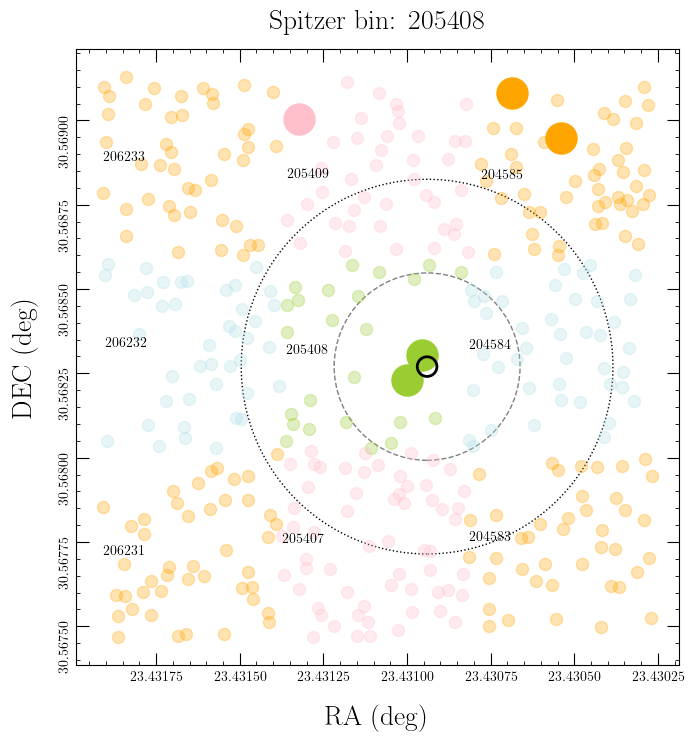

In [969]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)

bins = bins_dec

ax.set_aspect(m33_ar * 10/13)
#ax.set_ylim(30.4978, 30.499)
ax.set_xlabel('RA (deg)', fontsize=20)
ax.set_ylabel('DEC (deg)', fontsize=20)
ax.set_title('Spitzer bin: {}'.format(s_bin_num), fontsize=20)
ax.tick_params(axis='y', rotation=90)
ax.invert_xaxis()
ax.tick_params(axis='both', labelsize=10)

ax.scatter(spitzer['ra'][spitz_i], spitzer['dec'][spitz_i], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=200,
           zorder=5,
           linewidths=2
          )

#ax.scatter(spitzer['ra'][same_bins], spitzer['dec'][same_bins], 
 #         color='black', 
  #        s=10)

psf = patches.Circle((spitzer['ra'][spitz_i], spitzer['dec'][spitz_i]), 
                     radius=1/3600, 
                     edgecolor='gray', 
                     facecolor=(0,0,0,0),
                     linestyle='--',
                     linewidth=1)

search_rad = patches.Circle((spitzer['ra'][spitz_i], spitzer['dec'][spitz_i]), 
                     radius=search_radius, 
                     edgecolor='black', 
                     facecolor=(0,0,0,0),
                     linestyle=':',
                     linewidth=1)
ax.add_patch(psf)
ax.add_patch(search_rad)

bb = [s_bin_num, s_bin_num+1, s_bin_num-1, s_bin_num+ bins - 1, s_bin_num- bins + 1, s_bin_num+ bins, s_bin_num- bins, s_bin_num+ bins - 2, s_bin_num- bins + 2]
cc = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']
#cc = ['xkcd:tangerine', 'greenyellow', 'greenyellow', 'turquoise', 'turquoise', 'coral', 'coral', 'coral', 'coral']

for i,bin in enumerate(bb):
    lox, = np.where(indgst == bb[i])
    ax.scatter(ra_gst[lox], dec_gst[lox],
               color=cc[i], s=75, alpha=0.3)
    
    final, = np.where(bin_nums_phatter == bb[i])
    ax.scatter(RA[final], DEC[final],
               color=cc[i], s=500)
    
    same_bins, = np.where((spitzer['ra'] < ra_gst[lox].max()) & (spitzer['ra'] > ra_gst[lox].min()) & (spitzer['dec'] > dec_gst[lox].min()) & (spitzer['dec'] < dec_gst[lox].max()) )
    #ax.scatter(spitzer['ra'][same_bins], spitzer['dec'][same_bins], color='black', s=10)

    ax.text(np.max(ra_gst[lox]), np.mean(dec_gst[lox]),
                str(bin), fontsize=10)
    

    
plt.savefig('./images/bin_visuals.png', bbox_inches='tight')

In [970]:
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')

In [971]:
f160_cc = phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [972]:
ar_length = len(RA)
flux_fracs_spitzer = np.full(ar_length, -999.9)
#flux_fracs_spitzer_2 = np.full(ar_length, -999.9)
flux_fracs_hst = np.full(ar_length, -999.9)
#flux_fracs_hst_2 = np.full(ar_length, -999.9)
dists = np.full(ar_length, -999.9)
spitzer_match_index = np.full(ar_length, -999)
match_ids = np.full(ar_length, -99)
spitz_cols = np.full(ar_length, -999.9)
spitz_mags = np.full(ar_length, -999.9)
delta_ras = np.full(ar_length, 999.9)
delta_decs = np.full(ar_length, 999.9)
num_matches = np.full(ar_length, 0)
max_ff = np.full(ar_length, 999.9)
snum = np.full(len(spitzer), -99)

In [973]:
ph_index = np.arange(0, ar_length, 1)
ph_full_ind = phatter.full_index.evaluate(selection='COL_CUT')

In [974]:
len(spitzer)

18697

In [975]:
def find_matches(spitzer, bins):
    i = spitzer['index']
    s_bin_i= bin_nums_spitz[i]
    loc, = np.where((bin_nums_phatter >= s_bin_i - bins) & (bin_nums_phatter <= s_bin_i + bins))
    
    delta_ra = (RA[loc] - spitzer['ra'][i])*np.cos(spitzer['dec'][i] * np.pi / 180)
    delta_dec = DEC[loc] - spitzer['dec'][i]
    
    dist = np.sqrt(delta_ra**2 + delta_dec**2)
    
    matched, = np.where(dist <= search_radius)
    indices = [loc][matched]

In [976]:
%%time
###Number of bins should match the number chosen for reverse indices above
bins = bins_dec

for i,source in enumerate(spitzer):
    ###Get bin of spitzer source
    s_bin_i= bin_nums_spitz[i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((bin_nums_phatter >= s_bin_i - bins) & (bin_nums_phatter <= s_bin_i + bins))
     
    ###Get the distance between each PHATTER source and the spitzer source
    delta_ra = (RA[loc] - spitzer['ra'][i])*np.cos(spitzer['dec'][i] * np.pi / 180)
    delta_dec = DEC[loc] - spitzer['dec'][i]
    
    dist = np.sqrt(delta_ra**2 + delta_dec**2)
                                                   
    
    ###Get indices of PHATTER sources where the above distance is 2" or less                                                                                                                                              
    matched, = np.where(dist <= search_radius)
    indices = ph_index[loc][matched]
    snum[i] = len(matched)

    
    if len(matched) != 0:

        match_ids[indices] = spitzer['index'][i]

        ###Fraction of the 3.6 flux of every matched HST source over the 3.6 flux of spitzer source [i]                                                               
        flux_frac_s = FD_36[indices] / spitzer['fd36'][i]
        #flux_frac_s2 = FD_36_2[indices] / spitzer['fd36'][i]
        ###Fraction of the 3.6 flux of every matched HST source over the total of all matched HST sources
        tot_flux = np.sum(FD_36[indices])
        flux_frac_h = FD_36[indices] / tot_flux 
        
        #tot_flux2 = np.sum(FD_36_2[indices])
        #flux_frac_h2 = FD_36_2[indices] / tot_flux2
        ###Adds all matching data to appropriate arrays                                                                                                                                            
        dists[indices] = dist[matched]     
        flux_fracs_spitzer[indices] = flux_frac_s
        #flux_fracs_spitzer_2[indices] = flux_frac_s2
        flux_fracs_hst[indices] = flux_frac_h
        #flux_fracs_hst_2[indices] = flux_frac_h2
        spitzer_match_index[indices] = i
        delta_ras[indices] = delta_ra[matched]
        delta_decs[indices] = delta_dec[matched]
        num_matches[indices] = len(matched)
        max_ff[indices] = np.max(flux_frac_s)

        
        spitz_mag = spitzer[i]['mag36']
        spitz_col = spitzer[i]['mag36'] - spitzer[i]['mag45']
        spitz_mags[indices] = spitz_mag
        spitz_cols[indices] = spitz_col

CPU times: user 2.51 s, sys: 26.4 ms, total: 2.54 s
Wall time: 2.56 s


In [977]:
match, = np.where(match_ids != -99)

In [978]:
zrs, = np.where(snum == 0)

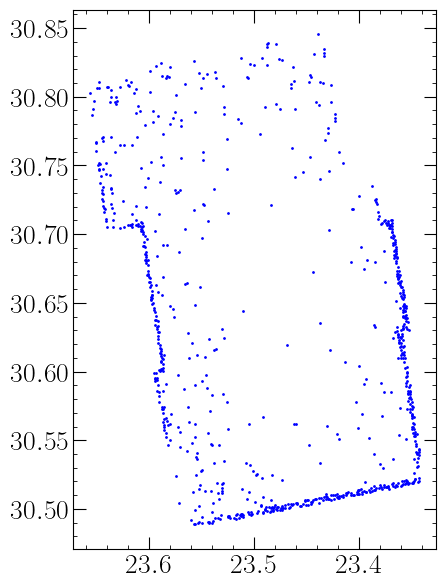

In [979]:
#spitzer sources that have no hst matches
fig, ax = plt.subplots(1)

ax.scatter(spitzer['ra'][zrs], spitzer['dec'][zrs], s=1, c='blue')
ax.invert_xaxis()
ax.set_aspect(m33_ar);

In [980]:
df, ffs, ffh = dists[match] / (search_radius), flux_fracs_spitzer[match], flux_fracs_hst[match]

In [981]:
c_matched = col[match]

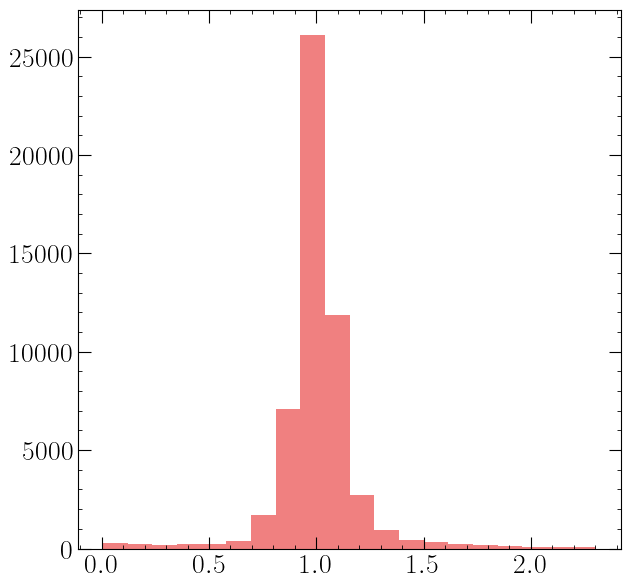

In [982]:
plt.hist(col[match], bins=20);

In [983]:
red_cols, = np.where(c_matched > 1.6)
wc = np.unique(match_ids[match][red_cols])

reds = np.full_like(spitzer['ra'], 0)

reds[wc] = 1
spitzer['flag_r'] = reds

In [984]:
spitz_ms, = np.where(np.array(snum) != 0)
spitzer_matched = spitzer[spitz_ms]
spitzer_matched.write('./spitzer_matched.csv', format='csv', overwrite=True)

In [985]:
f160w = phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [986]:
col_flag, = np.where(c_matched > 1.5)

In [987]:
no_ones, = np.where(ffh != 1.0)
ones, = np.where(ffh == 1.0)

In [988]:
hiffs, = np.where(ffs >= 2.0)

In [1061]:
def best_ff(spitzer_sources):
    best_ffs = []
    for source in spitzer_sources:
        try:
            i = source['index']
            matches = np.where(match_ids == i)
            best = np.argmin(np.absolute(FD_36[matches] - source['fd36']))
            bf = ph_index[matches][best]
            best_ffs.append(bf)
        except:
            best_ffs.append(-99)
    return np.array(best_ffs)

In [1062]:
bf_index = best_ff(spitzer_matched)

In [1063]:
len(flux_fracs_spitzer), len(ph_index)

(120927, 120927)

In [1064]:
gd, = np.where(bf_index != -99) 

In [1149]:
hi, = np.where(flux_fracs_spitzer[bf_index][gd] > 1)

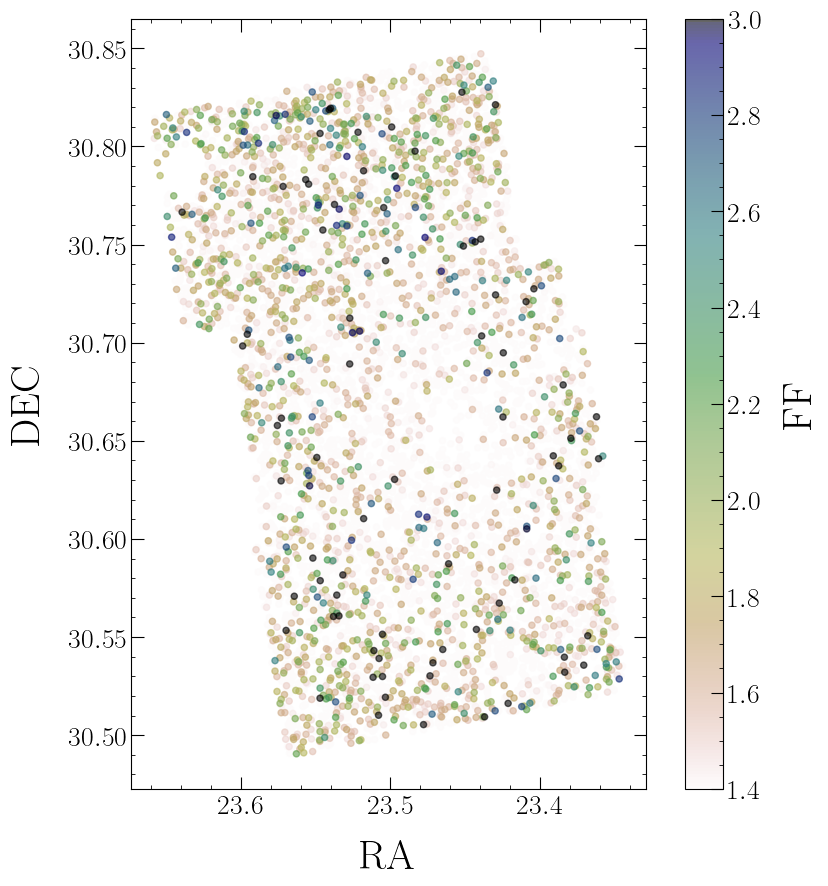

In [1202]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)


ss = np.argsort(flux_fracs_spitzer[bf_index][gd][hi])#[::-1]
plot = ax.scatter(spitzer_matched['ra'][gd][hi][ss], spitzer_matched['dec'][gd][hi][ss], 
                  s=20, alpha=0.6,
                  c=flux_fracs_spitzer[bf_index][gd][hi][ss], 
                  cmap='gist_earth_r', 
                  vmin=1.4, vmax=3
                 )

ax.invert_xaxis()
ax.set_aspect(m33_ar)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
plt.colorbar(plot, ax=ax, label='FF');


plt.savefig('./images/hi_ff_map.png', bbox_inches='tight')

In [991]:
hst_id = phatter.index.evaluate(selection='COL_CUT')[match]

In [992]:
match_data = aspy.table.Table([hst_id, match_ids[match], RA[match], DEC[match], df, ffs, ffh, c_matched], 
                              names=['hst_index', 'match_index', 'ra', 'dec', 'df', 'ffs', 'ffh', 'col'])
match_data.write('./match_data.csv', format='csv', overwrite=True)

In [993]:
#selections of cutout plots for paper figures

#hi ff - k=539
hfm, = np.where((ffs > 0.75) & (ffs < 1.0))

#extra ff - k=466
efm, = np.where(ffs > 1.0)

#low ff - k=200
lfm, = np.where(max_ff[match] < 0.2)

#clusters - k=0
cfm, = np.where(snum > 10)



In [994]:
#number of plots - multiple of 4
n = 16
#Spitzer index to start at
k = 200
###Get the first n spitzer object IDs for sources that have matches
#first_n = np.unique(match_ids[match])[k:k+n]

first_n = np.unique(match_ids[match][lfm])[k:k+n]
#first_n = cfm[k:k+n]

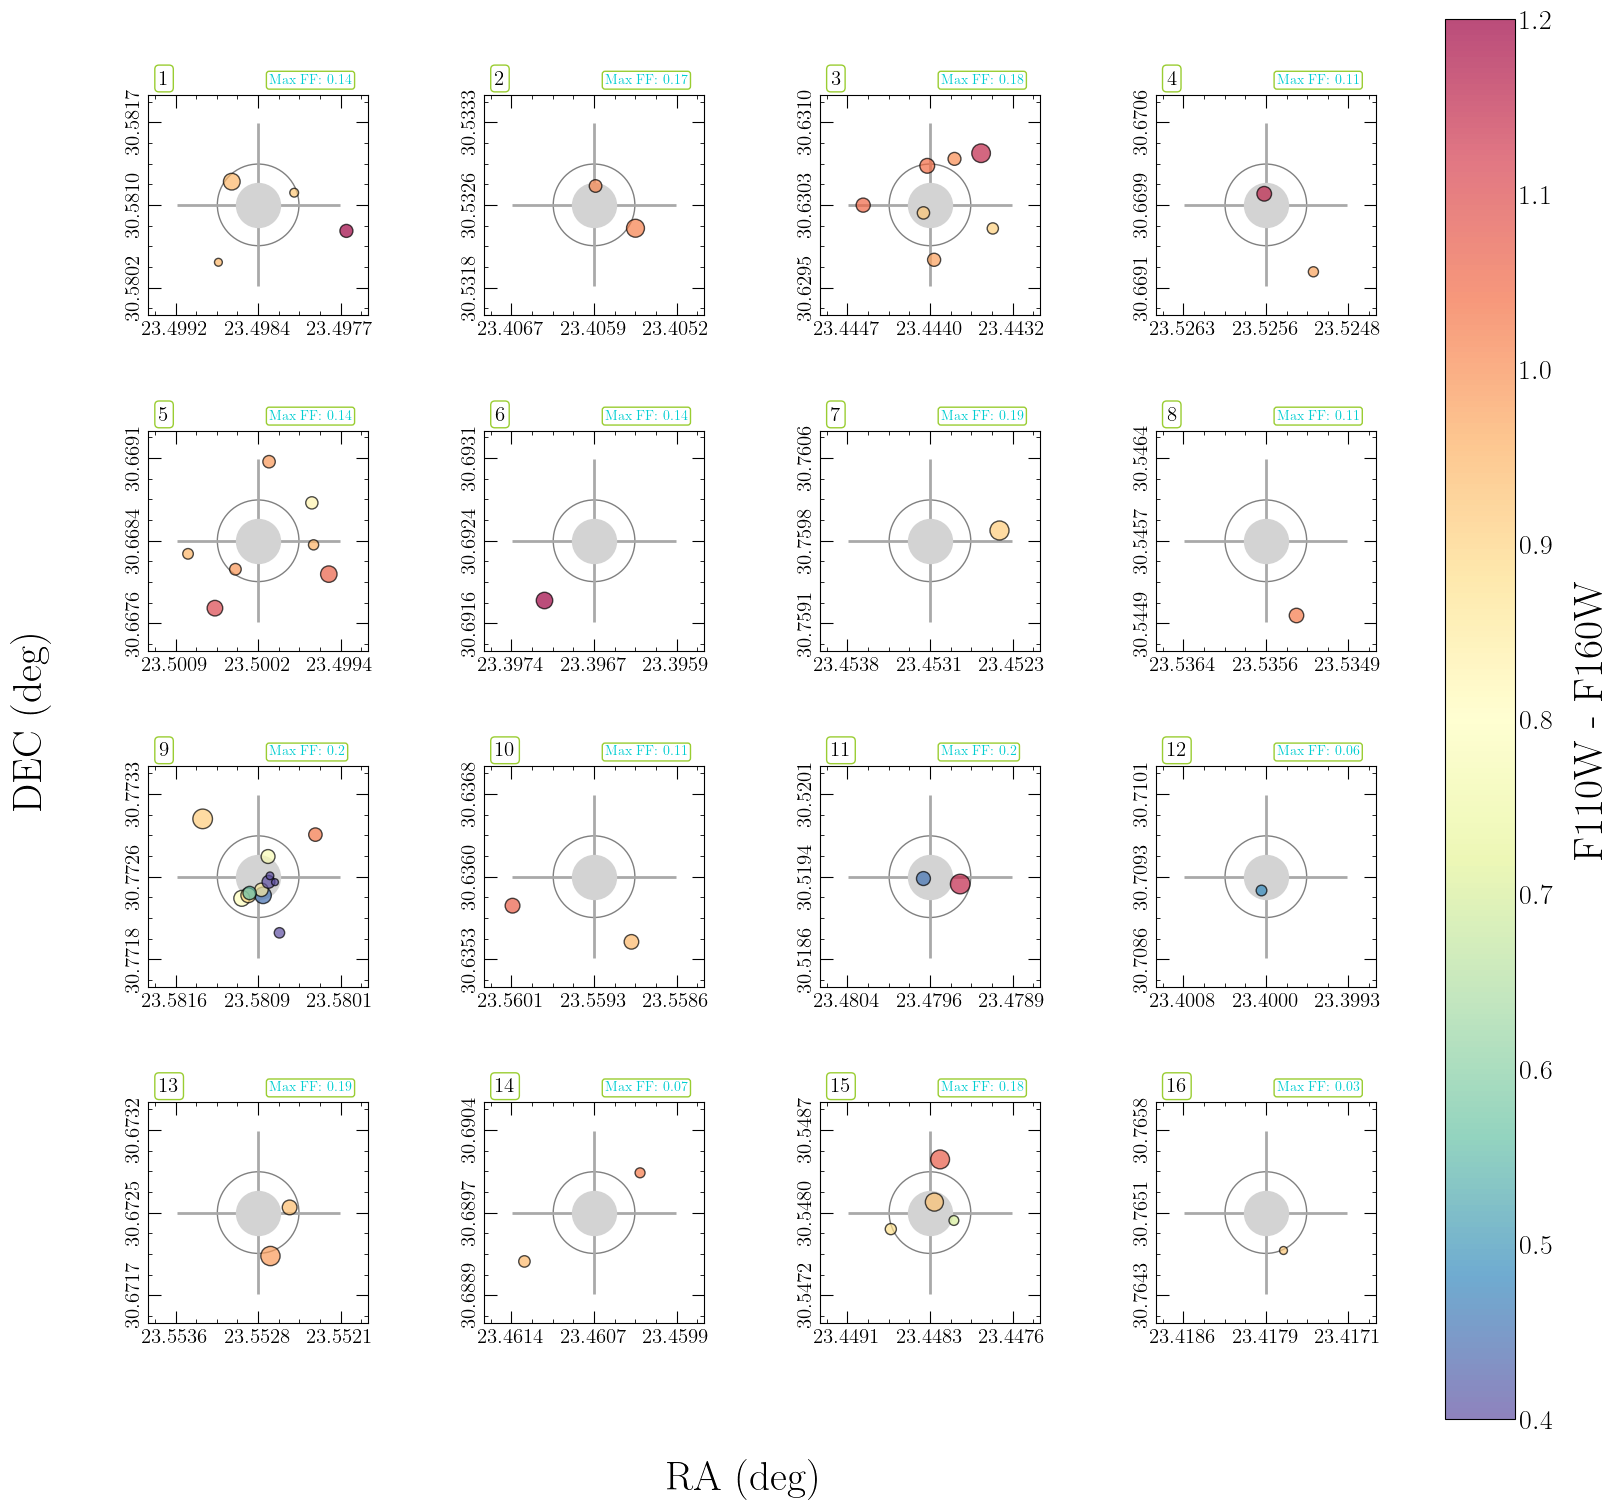

In [995]:
fig, axs = plt.subplots(int(n/4),4, figsize=(14,14*(n/16)))
fig.tight_layout(h_pad=1, w_pad=1)


for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(spitzer['index'] == first_n[i])
 ph, = np.where(match_ids[match] == first_n[i])
    
 matches_ffs = ffs[ph]
 #matches_ffs2 = ffs2[ph]
 colors_match = c_matched[ph]
 cmh = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
 ordered = np.argsort(matches_ffs)[::-1]
 #ordered2 = np.argsort(matches_ffs2)[::-1]
 max_ffs = matches_ffs[ordered][0].round(2)
 #max_ffs2 = matches_ffs2[ordered2][0].round(2)
 num = num_matches[match][ph]
    
 ax.set_aspect(1)   

 ax.errorbar(spitzer['ra'][ob], spitzer['dec'][ob], 
              xerr=search_radius, yerr=search_radius, 
            color='darkgrey', 
            linewidth=2)
 psf_circle = patches.Circle((spitzer['ra'][ob], spitzer['dec'][ob]), 
                            1/3600,
                            edgecolor='grey', facecolor='none', 
                            linestyle='-')
 sc = (spitzer['mag36'][ob] - spitzer['mag45'][ob]).value.round(2)
 ax.add_patch(psf_circle)

 wplot = ax.scatter(spitzer['ra'][ob], spitzer['dec'][ob], 
           s=1e3,
           c='lightgrey',
           label='Spitzer Source', 
           zorder=5)
 ss = np.argsort(matches_ffs)[::-1]
 cplot = ax.scatter(RA[match][ph][ss], 
                   DEC[match][ph][ss], 
                     s=matches_ffs[ss]*1e3, 
                     edgecolors='black', 
                     c=colors_match[ss], 
                     cmap=cmh, 
                     vmin=0.4, vmax=1.2, 
                     label='HST Matches', 
                     alpha=0.7,
                     zorder=7) 
 
 #red, = np.where((c_matched[ph] > 0.7) & (c_matched[ph] < 1.6)) 
 #if len(red) != 0:
  #  cplot2 = ax.scatter(RA[match][ph][red], 
   #                DEC[match][ph][red], 
    #                 s=matches_ffs2[red]*1e3,
     #               edgecolor='black', facecolor='none',
      #              linewidth=1,linestyle='--',
       #                 zorder=8
        #             )
 
 x,y = spitzer['ra'][int(ob)], spitzer['dec'][int(ob)]
 dx, dy = 0.00075, 0.00075
 ax.set_xlim(x+dx, x-dx)
 ax.set_xticks([x-dx*0.75, x, x+dx*0.75])
 ax.set_xticklabels(["{:.4f}".format(x-dx),"{:.4f}".format(x),"{:.4f}".format(x+dx)], ha='center')
 ax.set_ylim(y-dy, y+dy)
 ax.set_yticks([y-dy*0.75, y, y+dy*0.75])
 ax.set_yticklabels(["{:.4f}".format(y-dy),"{:.4f}".format(y),"{:.4f}".format(y+dy)], va='center')
 ax.tick_params(axis='x',labelsize=15)
 ax.tick_params(axis='y',labelsize=15, rotation=90)


 maxf_text = ax.text(x-dx*0.1, y+dy*1.1, 'Max FF: ' + str(max_ffs), 
         fontsize=10, fontweight='bold', 
         color='darkturquoise', 
         bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen', lw=1)
                    )
 
 plotnum_text = ax.text(x+dx*0.9, y+dy*1.1, str(i+1),
                       fontsize=15, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen'))
# end of loop

hst_cax = fig.add_axes([1.0, 0.0, 0.05, 1])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

fig.text(0.5, -0.05, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.025, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

#hfm
#plt.savefig('./images/cps_good_ff.png', bbox_inches='tight')

#efm
#plt.savefig('./images/cps_over_ff.png', bbox_inches='tight')

#lfm
#plt.savefig('./images/cps_low_ff.png', bbox_inches='tight')

#cfm
#plt.savefig('./images/cps_clusters.png', bbox_inches='tight')

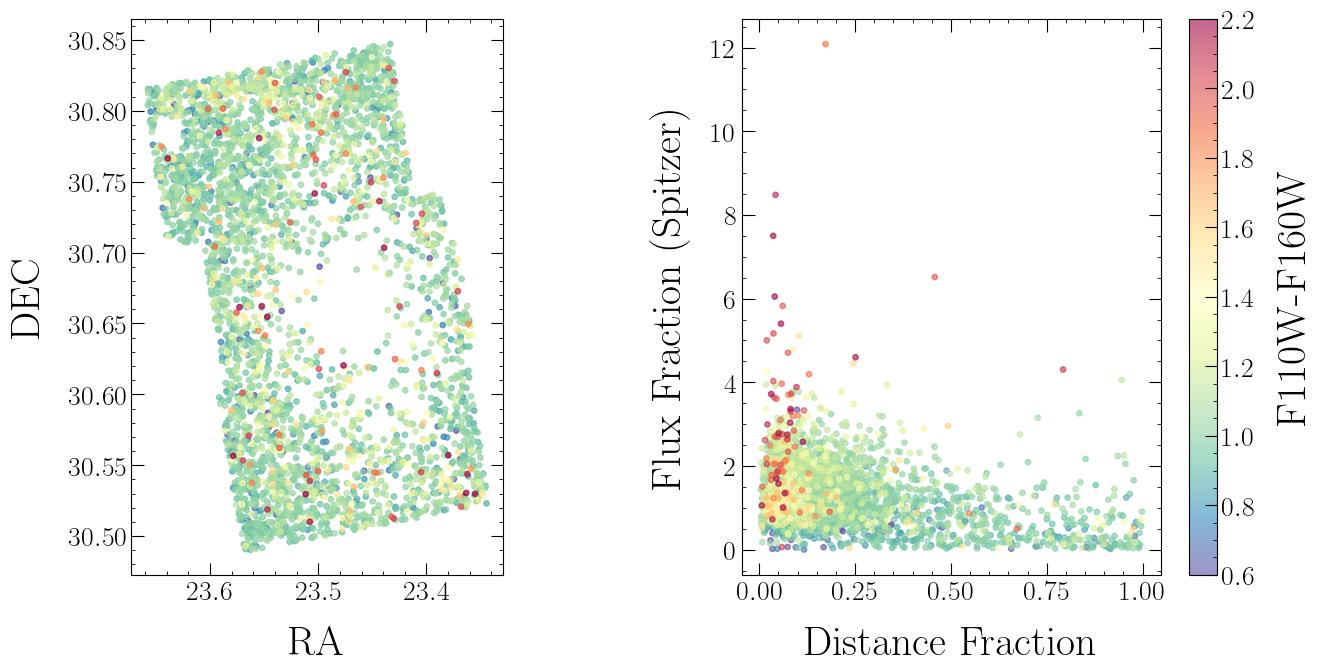

In [1174]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(14,7)
fig.tight_layout()

ss = np.argsort(col[match][ones])#[::-1]
plot1 = ax1.scatter(RA[match][ones][ss], DEC[match][ones][ss], 
                    s=15, alpha=0.7,
                    c=col[match][ones][ss], 
                    cmap='Spectral_r', 
                    vmin=0.6, vmax=2.2, 
                    
                    )
ax1.invert_xaxis()
ax1.set_aspect(m33_ar)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')


plot2 = ax2.scatter(df[ones][ss], ffs[ones][ss], 
                   c=col[match][ones][ss], 
                   cmap='Spectral_r', 
                   vmin=0.6, vmax=2.2, 
                   s=15, alpha=0.6);
ax2.set_xlabel('Distance Fraction')
ax2.set_ylabel('Flux Fraction (Spitzer)')
ax2.set_aspect(m33_ar/12)
plt.colorbar(plot2, ax=ax2, label='F110W-F160W');

#fig.text(0.5, 1.1, 'Sources w/ One HST Match', fontsize=50, ha='center');

plt.savefig('./images/single_match_map.png', bbox_inches='tight')

## Random Matches

In [997]:
np.random.seed(6903)
shuf_ra = ra_spitz
shuf_flux = spitzer['fd36'].value
np.random.shuffle(shuf_ra)
np.random.shuffle(shuf_flux)

np.random.seed(1230949)
shuf_dec = dec_spitz
np.random.shuffle(shuf_dec)

random_index = np.arange(len(spitzer), 1)

In [998]:
d_rand = np.full(ar_length, -999.9)
ff_rand_spitz = np.full(ar_length, -999.9)
ff_rand_hst = np.full(ar_length, -999.9)
ras_rand = np.full(ar_length, -999.9)
decs_rand = np.full(ar_length, -999.9)
spitz_ind = np.full(ar_length, -99)
cols_rand = np.full(ar_length, -999.9)

In [999]:
for i,source in enumerate(shuf_ra):                
    dd = np.sqrt( ((RA - shuf_ra[i])*np.cos(shuf_dec[i] * np.pi / 180))**2 + 
               (DEC - shuf_dec[i])**2)
    fmatched, = np.where(dd <= search_radius)

    if len(fmatched) != 0:
      fsm = FD_36[fmatched] / shuf_flux[i]
      ftot = np.sum(FD_36[fmatched])
      fsm2 = FD_36[fmatched] / ftot

      d_rand[fmatched] = dd[fmatched]
      ff_rand_spitz[fmatched] = fsm
      ff_rand_hst[fmatched] = fsm2
      ras_rand[fmatched] = RA[fmatched]
      decs_rand[fmatched] = DEC[fmatched]
      spitz_ind[fmatched] = i
      cols_rand[fmatched] = col[fmatched]

In [1000]:
rm, = np.where(d_rand != -999.9)

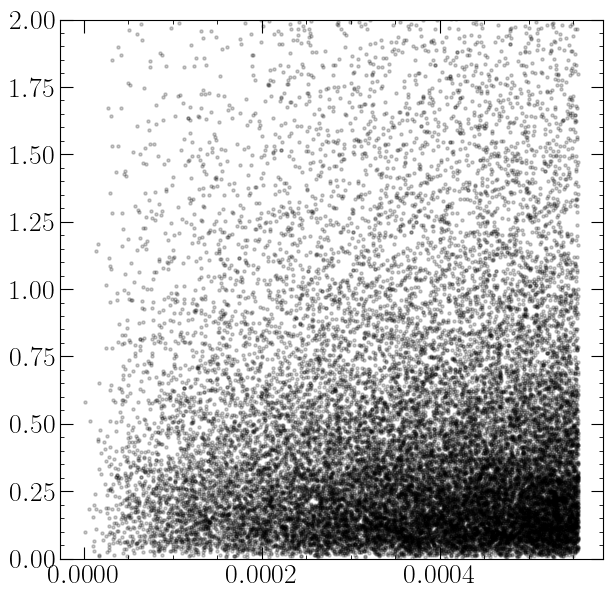

In [1001]:
fig, ax = plt.subplots(1)

ax.scatter(d_rand[rm], ff_rand_spitz[rm], c='black', s=5, alpha=0.2)
ax.set_ylim(0,2);

## Catalog

In [1002]:
#rand_no_ones, = np.where(f_shift_hst != 1.0)

In [1003]:
#k, = np.where(f_shift_spitzer[rand_no_ones] < 2)

In [1004]:
bright_hst, = np.where(f160_cc[match] < 15)

In [1005]:
obs_df_data = {'dist_frac':df,
               'flux_frac_spitzer':ffs,
               'flux_frac_hst':ffh,
               '110_160_col':col[match]
              }

rand_df_data = {'dist_frac':d_rand[rm] / search_radius,
               'flux_frac_spitzer':ff_rand_spitz[rm],
               'flux_frac_hst':ff_rand_hst[rm],
               '110_160_col':cols_rand[rm]
              } 

In [1006]:
rand = aspy.table.Table(rand_df_data)
rand.write('./random.csv', names=['dist_frac', 'flux_frac_spitzer', 'flux_frac_hst', 'f110_f160'], overwrite=True)

In [1007]:
obs = aspy.table.Table(obs_df_data)
obs.write('./observed.csv', names=['dist_frac', 'flux_frac_spitzer', 'flux_frac_hst', 'f110_f160'], overwrite=True)

In [1008]:
kde_probs = pd.read_csv('./kde_probs.csv')

In [1009]:
kde_probs.head()

Unnamed: 0  good_prob  rand_prob
0           0   5.263397   0.009014
1           1   0.022892   0.029125
2           2   5.529316   0.023800
3           3   6.844731   0.030852
4           4   6.407150   0.012841

In [1010]:
f275 = phatter.F275W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f336 = phatter.F336W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f475 = phatter.F475W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f814 = phatter.F814W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f110 = phatter.F110W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
f160 = phatter.F160W_VEGA.evaluate(selection='COL_CUT')[match][no_ones]
full_index = phatter.full_index.evaluate(selection='COL_CUT')[match][no_ones]

In [1011]:
##Add J, H, and K?

In [1012]:
columns = [RA[match][no_ones], DEC[match][no_ones], delta_ras[match][no_ones], delta_decs[match][no_ones], 
           f275, f336, f475, f814, f110, f160,
           MAG_36[match][no_ones],
           spitzer_match_index[match][no_ones],
           full_index,
           spitzer['mag36'][spitzer_match_index[match][no_ones]], 
           spitzer['mag45'][spitzer_match_index[match][no_ones]], 
           spitzer['mag58'][spitzer_match_index[match][no_ones]], 
           spitzer['mag80'][spitzer_match_index[match][no_ones]], 
           spitzer['mag24'][spitzer_match_index[match][no_ones]],
           df[no_ones], ffs[no_ones], ffh[no_ones],
           kde_probs['good_prob'], kde_probs['rand_prob'],
           num_matches[match][no_ones]
          ]

In [1013]:
names = ['ra', 'dec', 'delta_ra', 'delta_dec', 
         'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA', 'F110W_VEGA', 'F160W_VEGA',
         'estimated_36mag',
         'spitzer_index', 
         'PHATTER_index', 
         'mag36', 'mag45', 'mag58', 'mag80', 'mag24', 
         'frac_dist', 'frac_flux_s', 'frac_flux_h',
         'good_prob', 'rand_prob',
         'num_matches'
        ]

In [1014]:
#catalog = pd.DataFrame(data=columns, columns=names)
#catalog = aspy.table.Table(columns, names=names)

In [1015]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

#objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [1016]:
#m, = np.where(objid_key['unwise_objid'] != '****************')

In [1017]:
#objid_key[m].write('objid_key.csv')


## SED Plots

In [1018]:
from synphot import SourceSpectrum
from synphot.models import BlackBodyNorm1D
from synphot import units
sp = SourceSpectrum(BlackBodyNorm1D, temperature=5000*u.K)

In [1019]:
spitzer[:3]

<Table length=3>
        ra                dec          mag36    e36   ...     fd80          fd24      flag_r
     float64            float64       float32 float32 ...   float32       float32    float64
------------------ ------------------ ------- ------- ... ------------ ------------- -------
23.430829999999997 30.775179999999995    9.49    0.02 ...  0.013154097  0.0014842914     1.0
23.588489999999997 30.656899999999997   11.52    0.02 ... 0.0019909523 0.00034955807     1.0
23.539909999999995 30.652079999999994   12.29    0.05 ...  0.009016982   0.010556481     0.0

In [1020]:
no_24, = np.where(np.isnan(spitzer['mag24']))
no_24

array([ 1215,  1258,  1816,  2253,  3832,  6587,  8113,  8866,  9681,
       10046, 10681, 11139, 11228, 13322, 14422, 14548, 14564, 15342,
       15491, 15889, 15917, 16315, 16582, 17350])

In [1021]:
fd36 = spitzer['fd36'][spitzer_match_index[match][no_ones]]
fd45 = spitzer['fd45'][spitzer_match_index[match][no_ones]]
fd58 = spitzer['fd58'][spitzer_match_index[match][no_ones]]
fd80 = spitzer['fd80'][spitzer_match_index[match][no_ones]]
fd24 = spitzer['fd24'][spitzer_match_index[match][no_ones]]

In [1022]:
wave275, wave336, wave475, wave814, wave110, wave160 = 275 * u.nm, 336 * u.nm, 475 * u.nm, 814 * u.nm, 1100 * u.nm, 1600 * u.nm

In [1023]:
mags275, mags336, mags475, mags814, mags110, mags160 = f275 * VEGAmag, f336 * VEGAmag, f475 * VEGAmag, f814 * VEGAmag, f110 * VEGAmag, f160 * VEGAmag

NameError: name 'VEGAmag' is not defined

In [ ]:
fd275, fd336, fd475, fd814, fd110, fd160 = mags275.to('Jy', spectral_density_vega(wave275)), mags336.to('Jy', spectral_density_vega(wave336)), mags475.to('Jy', spectral_density_vega(wave475)), mags814.to('Jy', spectral_density_vega(wave814)), mags110.to('Jy', spectral_density_vega(wave110)), mags160.to('Jy', spectral_density_vega(wave160))

In [ ]:
seds_all = (np.array([fd275, fd336, fd475, fd814, fd110, fd160, fd36, fd45, fd58, fd80]).T) * 1e3

In [ ]:
filters_nm = np.array([275, 336, 475, 814, 1100, 1600, 3600, 4500, 5800, 8000])
filters_um = filters_nm / 1e3

In [ ]:
ff_select, = np.where((ffs[no_ones] > 0.9) & (ffs[no_ones] < 1.1))

In [ ]:
best_matches, = np.where((kde_probs['good_prob'] > 5) & (kde_probs['rand_prob'] < 0.1))
len(best_matches)

In [ ]:
rand_matches, = np.where((kde_probs['rand_prob'] > 7))
len(rand_matches)

In [ ]:
no_nans, = np.where([~np.isnan(sed).any() for sed in seds_all[ff_select]])

In [ ]:
no_nans2, = np.where([~np.isnan(sed).any() for sed in seds_all[best_matches]])

In [ ]:
def rj_curve(T_eff, lam):
    F_lambda = (2 * C.c * C.k_B * T_eff) / (lam**4)
    F_nu = F_lambda.to(u.W / u.m**3).value * ((lam.to(u.um).value)**2 / (C.c.to(u.um / u.s).value))
    return F_nu

In [ ]:
lambdas = np.linspace(0.1, 25, 1000)*u.um

In [ ]:
low_ff, = np.where(ffs[no_ones] < 0.1)

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)

i = 100
temps = np.arange(2000, 12000, 2000)


#for temp in temps:
#    rj_tail = rj_curve(temp*u.K, lambdas)
#    ax.plot(lambdas, rj_tail, label=str(temp) + 'K')

ax.set_xscale('log')
ax.set_xticks([1, 3, 9])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel(r'$\lambda$ [$\mu m$]')#'  $[\mu m]$')
ax.set_ylabel(r'$F_\nu$ [mJy]')
ax.set_title('SEDS - Best Matches')

#for sed in seds_all[]:
#    ax.plot(filters_um, sed), c='red')
mms =  [0, 14, 14.5, 15, 15.5, 16, 16.5, 20]
sed_cols = ['violet', 'purple', 'cyan', 'limegreen', 'yellow', 'orange', 'red']
for i in range(len(mms) - 1):
    mag_select, = np.where((spitzer['mag36'][spitzer_match_index[match][no_ones]] > mms[i]) & (spitzer['mag36'][spitzer_match_index[match][no_ones]] <= mms[i + 1]))
    ax.plot(filters_um, np.log10(np.nanmedian(seds_all[mag_select], axis=0)), c=sed_cols[i]);

In [ ]:
spitz_filters = [3.6, 4.5, 5.8, 8, 24]

In [ ]:
spitz_seds = np.array([fd36, fd45, fd58, fd80, fd24]).T

In [ ]:
spitzer[0]

In [ ]:
fig, ax = plt.subplots(1)

cmap = cm.get_sub_cmap('viridis', 0.0, 1.0)
cmap.set_under('w')

ax.scatter(spitzer['mag36'] - spitzer['mag45'], spitzer['mag45'], s=20, c='blue', alpha=0.05)#bins=50, cmap=cmap, vmin=1)
ax.set_xlim(-1,1.5)
ax.set_ylim(12,20)
ax.invert_yaxis();

In [ ]:
sec1, = np.where((spitzer['mag36'] - spitzer['mag45'] < 0.1) & (spitzer['mag45'] < 15.5))
sec2, = np.where((spitzer['mag36'] - spitzer['mag45'] < 0.1) & (spitzer['mag45'] > 15.5) & (spitzer['mag45'] > 17))
sec3, = np.where((spitzer['mag36'] - spitzer['mag45'] > 0.1) & (spitzer['mag45'] < 16.25))

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(spitz_filters)
ax.tick_params(axis='x', rotation=90)
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel(r'$\lambda$ [$\mu m$]')#'  $[\mu m]$')
ax.set_ylabel(r'$F_\nu$ [Jy]')
ax.set_title('SEDS - Best Matches')

for sed in spitz_seds[test]:
    ax.plot(spitz_filters, sed, alpha=0.02, c='purple')

In [ ]:
spitz_seds[test][0]

In [ ]:
x = np.random.rand(10)
y = np.random.rand(10)

fig, ax = plt.subplots(1)
ss = np.argsort(x)
ax.scatter(x, y, s=[1, 10, 30, 60, 100, 150, 200, 400, 750, 1000], c='lightskyblue', alpha=0.7)
for s in ss:
